In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.stats import chisquare
from scipy.stats import linregress

In [2]:
# Setting up the dataframe

file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

In [3]:
# Possible functions to fit the data
def loglogt(t, p, q):
    return p*t + q

def logPmod(t, A, B, C):
    return A + B/t**C

def logt(t, p, q, r):
    return p*np.log(t*r) + q

def linear(x, p, q):
        return p*x + q

In [4]:
def select_bin_number_mod(x, m = 2, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    # added a factor exp(m-2) to take into account the exponential decrease of total N
    n_min = max([int(fraction*len(x)*np.exp(m-2)),10])
    print('For m = {} and N = {} the minimum number of events in the tail required is : {}'.format(m, len(x), n_min))
    print('Minimum accuracy expected : {}'.format(round(1 - 1/np.sqrt(n_min),2)))
    #n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
        
        if last_n > n[min_nbin-2]:
            print('-> reducing the final number of bins to {}: \n'.format(min_nbin - 1))
            nbin, bins = select_bin_number_mod(x, m = m, min_nbin = min_nbin - 1)
        else:   
            n, bin_extremes, _ = plt.hist(x, bins = nbin )
            plt.close()
            bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        
        return nbin, bins

In [6]:
# Function to plot waiting times with R condition (fixed m_min)
# (Usare qella di nico per il serpentone)

from scipy import optimize
from scipy.stats import chisquare

def plot_Pm_t_Rcondition(m, R_fractions, df, sigma_filter = 10):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    As = []
    Bs = []
    Cs = []
    chis = []
    ps = []
    
    #Repeat plots and fits for each R_max fraction
    for i in range(1, R_fractions+1):
        
        """
        # searching for the next event within r_lim to compute waiting time
        time_diff = []
        for j in range(1, len(X)):
            single_r = np.linalg.norm(X[j]-X[j-1])
            k=1
            while single_r > 1.0*i/R_fractions*r.max():
                single_r = np.linalg.norm(X[j+k]-X[j-1])
                k = k+1
                if (j+k)==len(r):
                    break
            if (j+k)==len(r):
                break
            else:
                time_diff.append((timem[j+k-1] - timem[j-1])/time_d.max())
        print("Sono stati rimossi {} eventi ({}%)\n"\
              .format(len(time_d)-len(time_diff), round(100*(1-(len(time_diff)/len(time_d))))))
        """

        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i)+"/"+str(R_fractions)+" * max_distance")
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("Sono stati rimossi {} eventi ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))))))
        
        """
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
        ax1.plot(time_d)
        #ax1.axhline(time_d.mean()*2 + sigma_filter*time_d.std(), c = 'r')
        prova = time_d[time_d != time_d.max()]
        maximum = prova.max()
        if time_d.max()*3/4 > maximum:
            time_d = prova
        #time_d = time_d[mask]
        #print('Eliminated samples : ', len(timem) - len(time_d) -1, '\n')
        ax2.plot(time_d)

        plt.show()
        plt.close()
        """
        

        # computing suitable sizes of bins
        bin_number, bins = select_bin_number(time_diff)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

        n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
        sigma_n = np.sqrt(n)
        ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
        ax1.legend(loc = 'upper right')
        ax1.set_yscale('log')

        print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

        # rescaling the tail entries with the number of bins merged into the tail
        n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
        # linear fit over the log of the entries
        #params1, _ = optimize.curve_fit(logP, bin_centers, np.log(n), p0 = [np.log(n[0]),-1])
        params1, _ = optimize.curve_fit(loglogt, bin_centers, np.log(n), p0 = [-1,5])
        [A,B] = params1
        print('A = {}\nB = {}\n'.format(round(A,2), round(B,2)))

        # chi squared and p-value tests
        chisq, p = chisquare(np.log(n), loglogt(bin_centers, *params1), ddof = 2 )

        ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
        ax2.plot(bin_centers, loglogt(bin_centers, *params1), 
                 label = 'A = {} \nB = {}\n$\chi^2$ = {} \np-value = {}'\
                 .format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(p,2)))
        ax2.legend()

        plt.show()
        plt.close()

        gridsize = (2, 3)
        fig = plt.figure(figsize=(10, 4))
        ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
        ax1.plot(time_diff)

        ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
        n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
        #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
        ax2.set_xscale('log')
        ax2.axis('off')
        plt.show()
        plt.close()

        # parameters of Pm from the one of logPm 
        #a = np.exp(A)
        #b = -B/time_d.max()
        
        #Add parameters in their lists
        As.append(A)
        Bs.append(B)
        #Cs.append(C)
        chis.append(chisq)
        ps.append(p)
        
    return As, Bs, chis, ps

In [20]:
# Function to plot waiting times with R condition (fixed m_min)

def plot_Pm_t_Rcondition_nico(m, R_fractions, df):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    
    #Repeat plots and fits for each R_max fraction
    for i in range(1, R_fractions+1):
        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i)+"/"+str(R_fractions)+" * max_distance")
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("{} events hav been removed ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))),2)))
 
        # computing suitable sizes of bins
        original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
        bin_number = len(bins) - 1

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))

        n_tailed, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2

         # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
        sigma_n = np.sqrt(n)
        ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
        #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
        ax1.set_yscale('log')
        ax1.set_xlabel('normalized waiting times', fontsize = 14)
        ax1.set_ylabel('occurrencies', fontsize = 14)
        ax1.set_title('Number of events = {}'.format(len(time_diff)))
        
        
         # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
        ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
        accuracies = 1 - 1./np.sqrt(n)
        plt.plot(bin_centers, accuracies, 'g.')
        plt.title('Accuracy')
        plt.xlabel('bin labels')
        #plt.ylabel('accuracy')
        #plt.ylim(bottom = 0, top = 1)
        plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])

        #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
        print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

        # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        #n = np.concatenate((n[:-1], n[-1:]/(original_bin_number+1-bin_number)))

        # linear fit over the log of the entries
        params1, _ = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
        [p,q] = params1
        #print('p = {}\nq = {}'.format(round(p,2), round(q,2)))

        # chi squared and p-value tests
        #chisq, pv = chisquare(np.log(n), loglogt(np.log(bin_centers), *params1), ddof = 2 )

        y_errors = 1./np.sqrt(n)
        ax2.errorbar(np.log(bin_centers), np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
        ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
                 label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
                 #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
                 #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
        ax2.legend()
        ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
        ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)

        # Finally we can plot in the first panel the obtained fit:
        x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
        #print(ax1)
        ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))

        plt.show()
        plt.close()

        #Add parameters in their lists
       
    return np.array(ps), np.array(qs)

R_max = 1/10 * max_distance
5126 events hav been removed (44.74%)

For m = 3 and N = 6331 the minimum number of events in the tail required is : 17
Minimum accuracy expected : 0.76
Number of bins merged into the tail: 3 



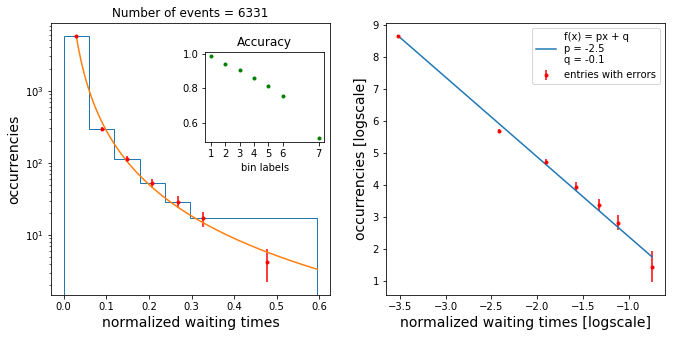

R_max = 2/10 * max_distance
3696 events hav been removed (32.26%)

For m = 3 and N = 7761 the minimum number of events in the tail required is : 21
Minimum accuracy expected : 0.78
-> reducing the final number of bins to 6: 

For m = 3 and N = 7761 the minimum number of events in the tail required is : 21
Minimum accuracy expected : 0.78
Number of bins merged into the tail: 6 



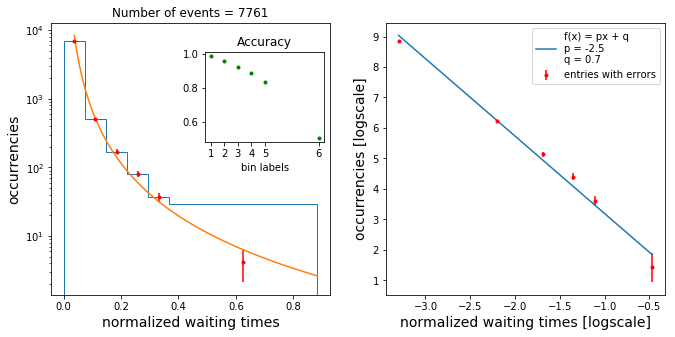

R_max = 3/10 * max_distance
2517 events hav been removed (21.97%)

For m = 3 and N = 8940 the minimum number of events in the tail required is : 24
Minimum accuracy expected : 0.8
Number of bins merged into the tail: 6 



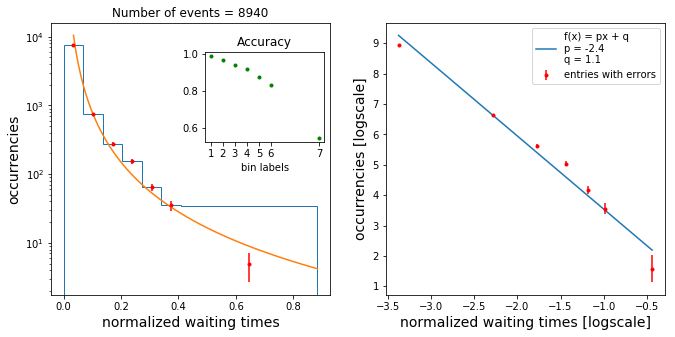

R_max = 4/10 * max_distance
1652 events hav been removed (14.42%)

For m = 3 and N = 9805 the minimum number of events in the tail required is : 26
Minimum accuracy expected : 0.8
Number of bins merged into the tail: 5 



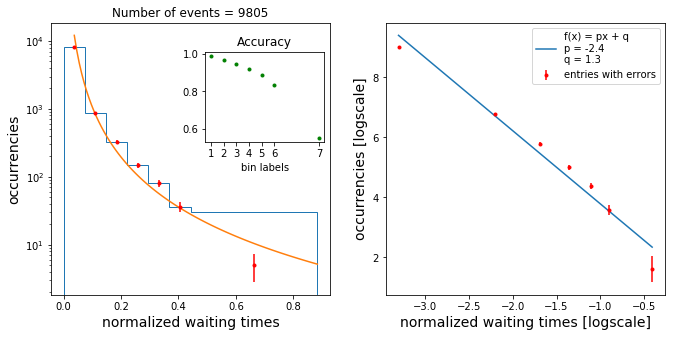

R_max = 5/10 * max_distance
943 events hav been removed (8.23%)

For m = 3 and N = 10514 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81
Number of bins merged into the tail: 6 



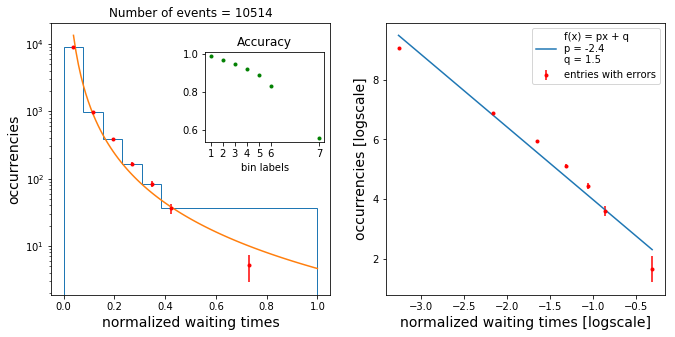

R_max = 6/10 * max_distance
463 events hav been removed (4.04%)

For m = 3 and N = 10994 the minimum number of events in the tail required is : 29
Minimum accuracy expected : 0.81
Number of bins merged into the tail: 5 



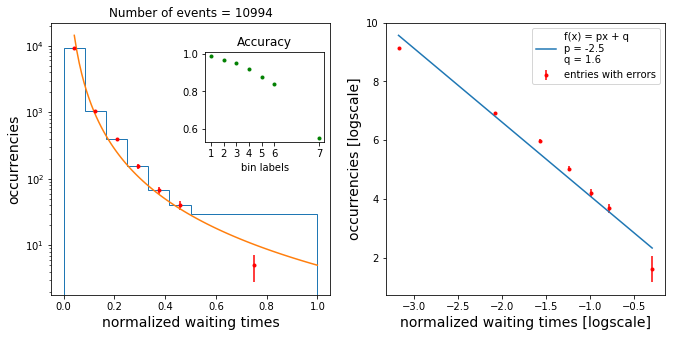

R_max = 7/10 * max_distance
117 events hav been removed (1.02%)

For m = 3 and N = 11340 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



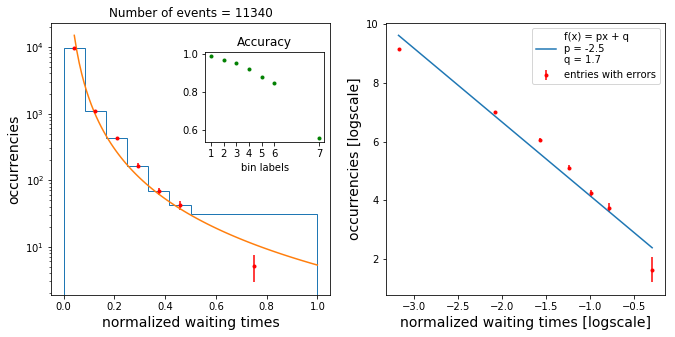

R_max = 8/10 * max_distance
18 events hav been removed (0.16%)

For m = 3 and N = 11439 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



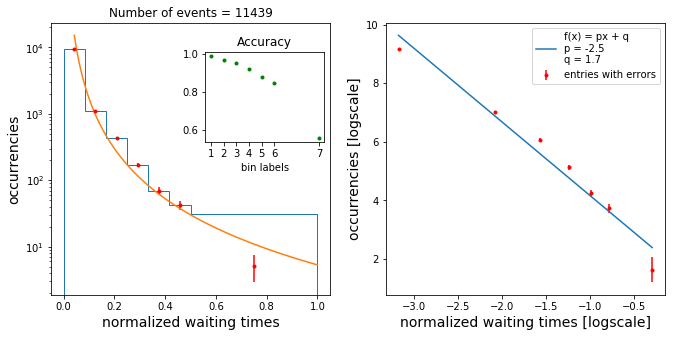

R_max = 9/10 * max_distance
5 events hav been removed (0.04%)

For m = 3 and N = 11452 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



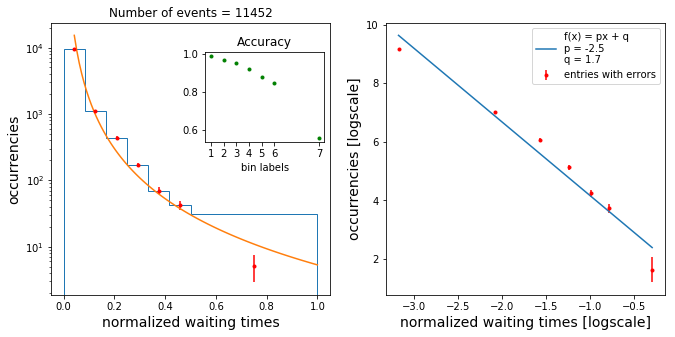

R_max = 10/10 * max_distance
0 events hav been removed (0.0%)

For m = 3 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



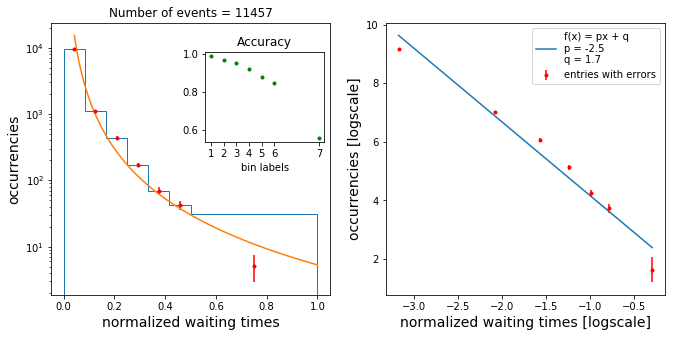

ValueError: not enough values to unpack (expected 4, got 2)

In [21]:
# Rifare plot cambiando funzione da fittare (non retta)
As, Bs, chis, ps = plot_Pm_t_Rcondition_nico(3,10,df)

p = 0.47
q = 8.92
t = 0.9



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


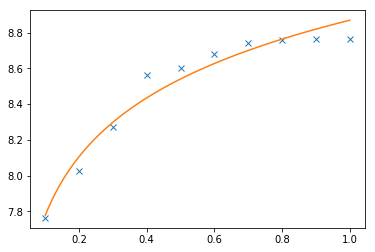

In [22]:
# Plot di B in funzione del raggio limite (waiting times minori per R bassi perchè decresce di più)
plt.plot(np.linspace(0.1,1,10), Bs, 'x') # R_lim dato come frazione di R_max
params_Bs, _ = optimize.curve_fit(logt, np.linspace(0.1,1,10), Bs)
print('p = {}\nq = {}\nt = {}\n'.format(round(params_Bs[0],2), round(params_Bs[1],2), round(params_Bs[2],2)))
plt.plot(np.linspace(0.1,1,100), logt(np.linspace(0.1,1,100), *params_Bs))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


p = 1.84
q = -14.45
t = 13.65



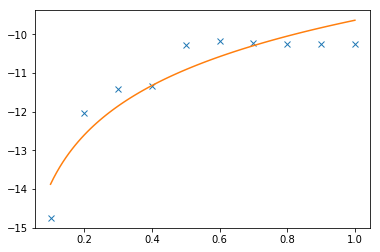

In [23]:
# Plot di A in funzione del raggio massimo
plt.plot(np.linspace(0.1,1,10), As, 'x')
params_As, _ = optimize.curve_fit(logt, np.linspace(0.1,1,10), As)
print('p = {}\nq = {}\nt = {}\n'.format(round(params_As[0],2), round(params_As[1],2), round(params_As[2],2)))
plt.plot(np.linspace(0.1,1,100), logt(np.linspace(0.1,1,100), *params_As))
plt.show()

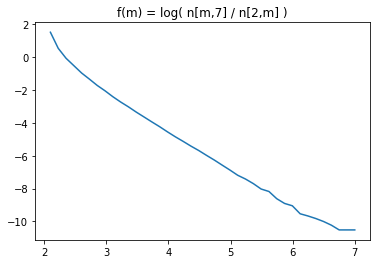

In [18]:
def func(x, df):
    return (len(df[df['magnitude'] > x])/len(df[df['magnitude'] < x]))

# plot of f(m) = log( n[m,7] / n[2,m] )
x = np.linspace(2.1,7,40)
y = []
for i in x:
    y.append(func(i,df))

plt.title('f(m) = log( n[m,7] / n[2,m] )')
plt.plot(x,np.log(y))
plt.show()

## Study of R_max as a function of m
### Metodo del 'serpentone'

In [125]:
# Function that computes waiting times with R condition without plotting (fixed m_min) 
# ('serpentone' taken from NICO and modified)

def Pm_t_Rcondition_snake (m, R_fractions, df):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = []
    Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
    print('R_max fractions considered: ', Rs, '\n')
    #Repeat plots and fits for each R_max fraction
    
z
    #for i in range(1, R_fractions+1):
    for i in range(R_fractions):
        
        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(Rs[i])+" * max_distance")
        #R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= Rs[i]*r.max())))
        dfmr = dfm[R_mask]
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("{} events hav been removed ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))),2)))
 
        # computing suitable sizes of bins
        original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
        bin_number = len(bins) - 1

        n_tailed, bin_extremes, _  = plt.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2

         # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))

        # linear fit over the log of the entries
        params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
        [p,q] = params1
        var_p = np.diag(cov1)[0]
        print('variance of exponent p = ', var_p)
        plt.close()
        
        #Add parameters in their lists
        ps.append(p)
        qs.append(q)
        p_errors.append(np.sqrt(var_p))
        
    return np.array(ps), np.array(qs), np.array(p_errors), r.max()

R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 0.1 * max_distance
53807 events hav been removed (50.67%)

For m = 2.0 and N = 52390 the minimum number of events in the tail required is : 52
Minimum accuracy expected : 0.86


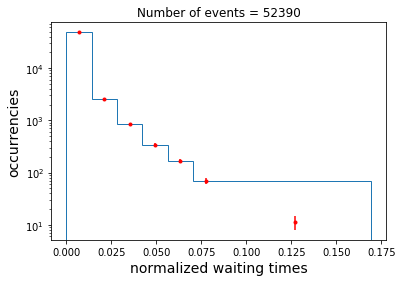

variance of exponent p =  0.018389406295065705
R_max = 0.12405595450583427 * max_distance
49914 events hav been removed (47.0%)

For m = 2.0 and N = 56283 the minimum number of events in the tail required is : 56
Minimum accuracy expected : 0.87


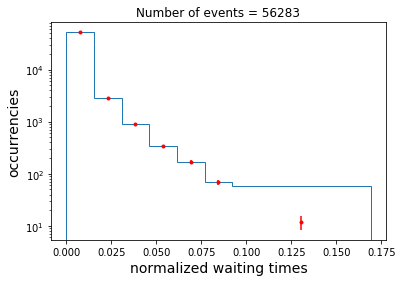

variance of exponent p =  0.02283011608593241
R_max = 0.15070218307242375 * max_distance
45810 events hav been removed (43.14%)

For m = 2.0 and N = 60387 the minimum number of events in the tail required is : 60
Minimum accuracy expected : 0.87


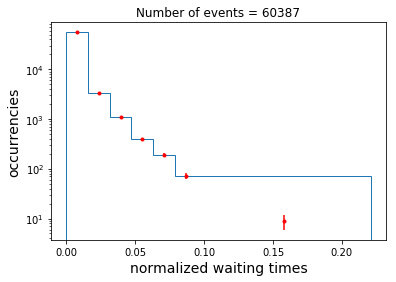

variance of exponent p =  0.022742314700326262
R_max = 0.17993868569976854 * max_distance
41174 events hav been removed (38.77%)

For m = 2.0 and N = 65023 the minimum number of events in the tail required is : 65
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 6: 

For m = 2.0 and N = 65023 the minimum number of events in the tail required is : 65
Minimum accuracy expected : 0.88


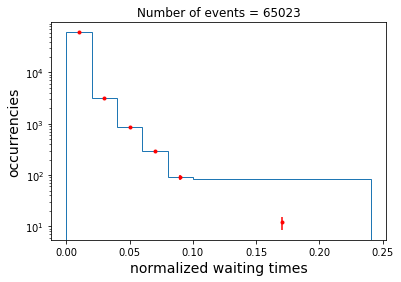

variance of exponent p =  0.01817698305647802
R_max = 0.21176546238786859 * max_distance
36079 events hav been removed (33.97%)

For m = 2.0 and N = 70118 the minimum number of events in the tail required is : 70
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 6: 

For m = 2.0 and N = 70118 the minimum number of events in the tail required is : 70
Minimum accuracy expected : 0.88


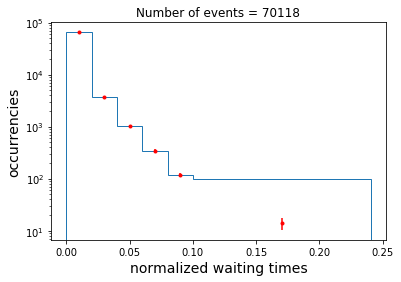

variance of exponent p =  0.020015928417137195
R_max = 0.24618251313672385 * max_distance
30437 events hav been removed (28.66%)

For m = 2.0 and N = 75760 the minimum number of events in the tail required is : 75
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 6: 

For m = 2.0 and N = 75760 the minimum number of events in the tail required is : 75
Minimum accuracy expected : 0.88


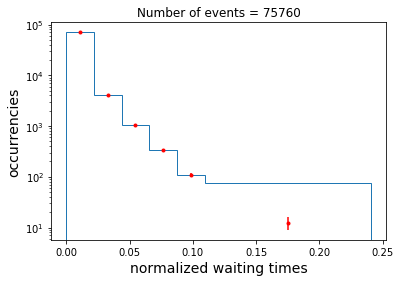

variance of exponent p =  0.03300201862790741
R_max = 0.28318983794633446 * max_distance
25063 events hav been removed (23.6%)

For m = 2.0 and N = 81134 the minimum number of events in the tail required is : 81
Minimum accuracy expected : 0.89


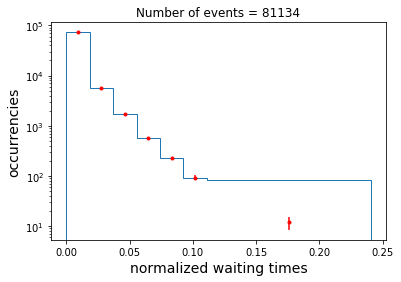

variance of exponent p =  0.03621405192578379
R_max = 0.32278743681670025 * max_distance
20425 events hav been removed (19.23%)

For m = 2.0 and N = 85772 the minimum number of events in the tail required is : 85
Minimum accuracy expected : 0.89


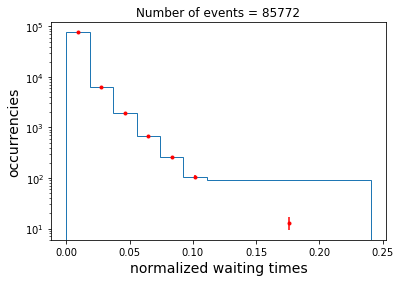

variance of exponent p =  0.04065443231761105
R_max = 0.3649753097478212 * max_distance
16826 events hav been removed (15.84%)

For m = 2.0 and N = 89371 the minimum number of events in the tail required is : 89
Minimum accuracy expected : 0.89


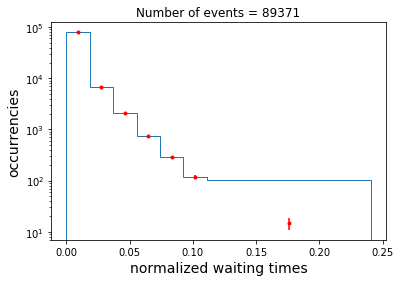

variance of exponent p =  0.04138868057614299
R_max = 0.4097534567396975 * max_distance
13369 events hav been removed (12.59%)

For m = 2.0 and N = 92828 the minimum number of events in the tail required is : 92
Minimum accuracy expected : 0.9


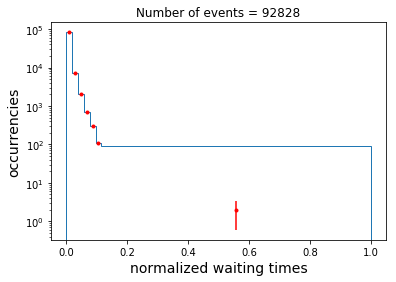

variance of exponent p =  0.011288622400958825
R_max = 0.45712187779232905 * max_distance
10190 events hav been removed (9.6%)

For m = 2.0 and N = 96007 the minimum number of events in the tail required is : 96
Minimum accuracy expected : 0.9


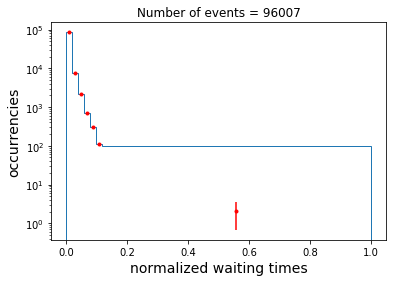

variance of exponent p =  0.011710385065281966
R_max = 0.507080572905716 * max_distance
7216 events hav been removed (6.79%)

For m = 2.0 and N = 98981 the minimum number of events in the tail required is : 98
Minimum accuracy expected : 0.9


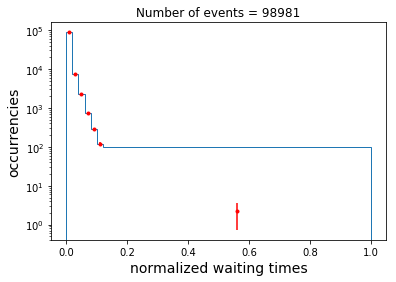

variance of exponent p =  0.010536292744732773
R_max = 0.5596295420798582 * max_distance
4551 events hav been removed (4.29%)

For m = 2.0 and N = 101646 the minimum number of events in the tail required is : 101
Minimum accuracy expected : 0.9


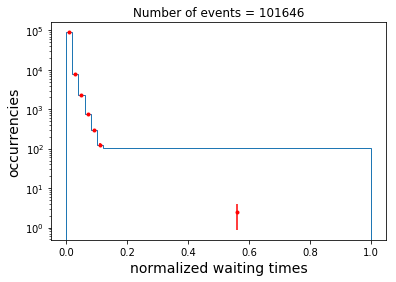

variance of exponent p =  0.011034173128962543
R_max = 0.6147687853147554 * max_distance
3103 events hav been removed (2.92%)

For m = 2.0 and N = 103094 the minimum number of events in the tail required is : 103
Minimum accuracy expected : 0.9


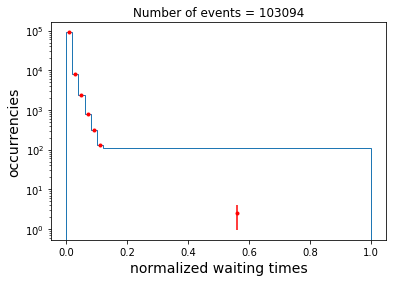

variance of exponent p =  0.0112301023041554
R_max = 0.672498302610408 * max_distance
1884 events hav been removed (1.77%)

For m = 2.0 and N = 104313 the minimum number of events in the tail required is : 104
Minimum accuracy expected : 0.9


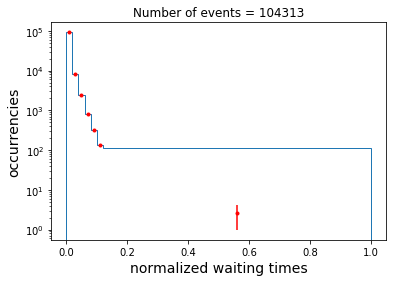

variance of exponent p =  0.011400111406192615
R_max = 0.7328180939668159 * max_distance
687 events hav been removed (0.65%)

For m = 2.0 and N = 105510 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


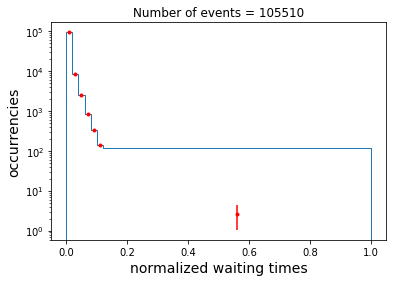

variance of exponent p =  0.01165533631358029
R_max = 0.7957281593839789 * max_distance
215 events hav been removed (0.2%)

For m = 2.0 and N = 105982 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


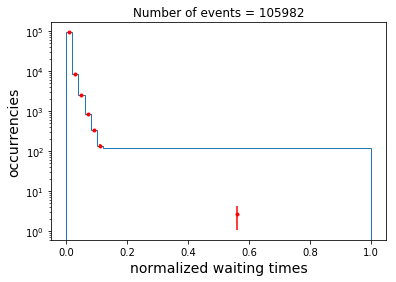

variance of exponent p =  0.011833679935514166
R_max = 0.8612284988618972 * max_distance
47 events hav been removed (0.04%)

For m = 2.0 and N = 106150 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


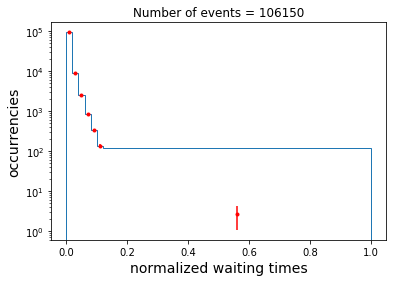

variance of exponent p =  0.011920876900679967
R_max = 0.9293191124005712 * max_distance
6 events hav been removed (0.01%)

For m = 2.0 and N = 106191 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


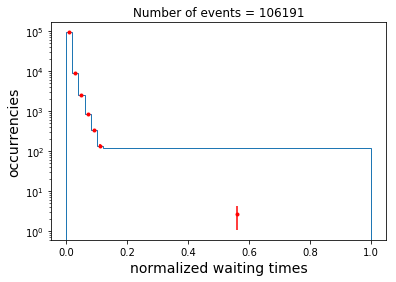

variance of exponent p =  0.011803654087570926
R_max = 1.0 * max_distance
0 events hav been removed (0.0%)

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


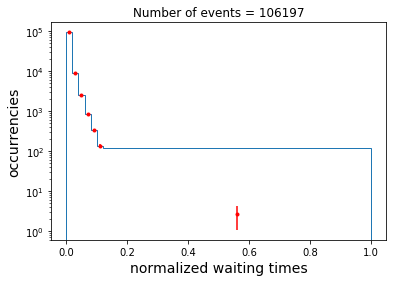

variance of exponent p =  0.011802789639177075
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 0.1 * max_distance
18489 events hav been removed (49.14%)

For m = 2.5 and N = 19132 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 19132 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
-> reducing the final number of bins to 5: 

For m = 2.5 and N = 19132 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


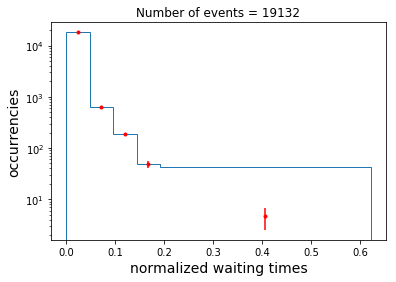

variance of exponent p =  0.006643201979583917
R_max = 0.12405595450583427 * max_distance
17274 events hav been removed (45.91%)

For m = 2.5 and N = 20347 the minimum number of events in the tail required is : 33
Minimum accuracy expected : 0.83
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 20347 the minimum number of events in the tail required is : 33
Minimum accuracy expected : 0.83


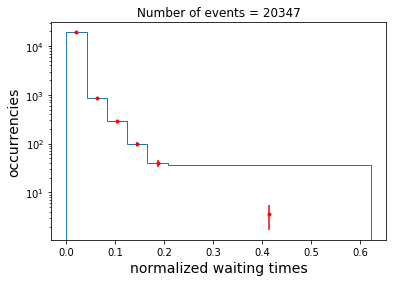

variance of exponent p =  0.006988722968662373
R_max = 0.15070218307242375 * max_distance
16090 events hav been removed (42.77%)

For m = 2.5 and N = 21531 the minimum number of events in the tail required is : 35
Minimum accuracy expected : 0.83
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 21531 the minimum number of events in the tail required is : 35
Minimum accuracy expected : 0.83
-> reducing the final number of bins to 5: 

For m = 2.5 and N = 21531 the minimum number of events in the tail required is : 35
Minimum accuracy expected : 0.83


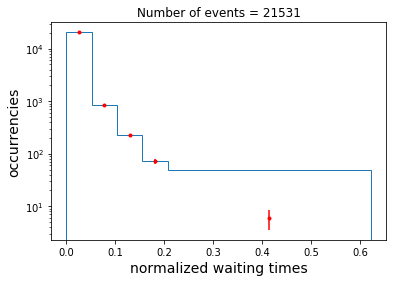

variance of exponent p =  0.00222922109480744
R_max = 0.17993868569976854 * max_distance
14785 events hav been removed (39.3%)

For m = 2.5 and N = 22836 the minimum number of events in the tail required is : 37
Minimum accuracy expected : 0.84


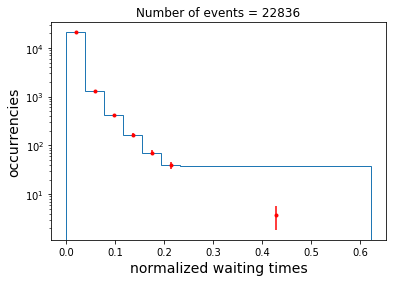

variance of exponent p =  0.011651102063695564
R_max = 0.21176546238786859 * max_distance
13147 events hav been removed (34.94%)

For m = 2.5 and N = 24474 the minimum number of events in the tail required is : 40
Minimum accuracy expected : 0.84


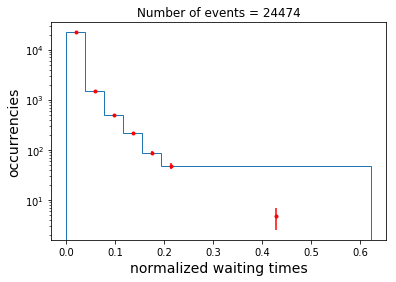

variance of exponent p =  0.014648958056531743
R_max = 0.24618251313672385 * max_distance
11386 events hav been removed (30.26%)

For m = 2.5 and N = 26235 the minimum number of events in the tail required is : 43
Minimum accuracy expected : 0.85
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 26235 the minimum number of events in the tail required is : 43
Minimum accuracy expected : 0.85


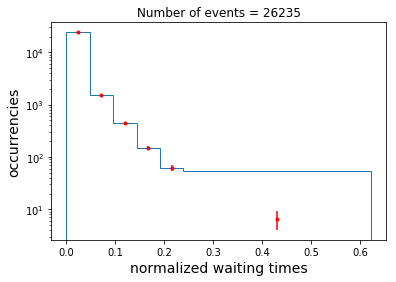

variance of exponent p =  0.01380476338073105
R_max = 0.28318983794633446 * max_distance
9745 events hav been removed (25.9%)

For m = 2.5 and N = 27876 the minimum number of events in the tail required is : 45
Minimum accuracy expected : 0.85
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 27876 the minimum number of events in the tail required is : 45
Minimum accuracy expected : 0.85


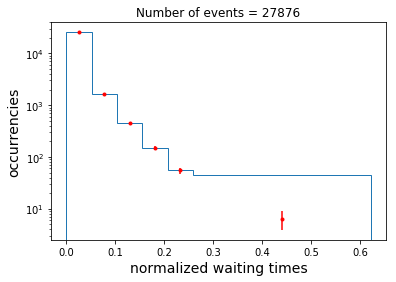

variance of exponent p =  0.021369975518090882
R_max = 0.32278743681670025 * max_distance
8294 events hav been removed (22.05%)

For m = 2.5 and N = 29327 the minimum number of events in the tail required is : 48
Minimum accuracy expected : 0.86
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 29327 the minimum number of events in the tail required is : 48
Minimum accuracy expected : 0.86


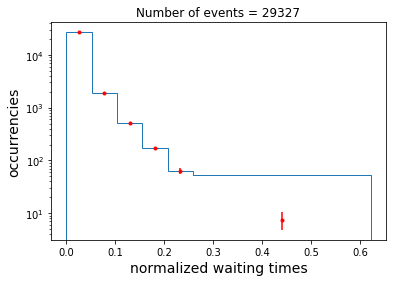

variance of exponent p =  0.022625960675094772
R_max = 0.3649753097478212 * max_distance
7044 events hav been removed (18.72%)

For m = 2.5 and N = 30577 the minimum number of events in the tail required is : 50
Minimum accuracy expected : 0.86
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 30577 the minimum number of events in the tail required is : 50
Minimum accuracy expected : 0.86


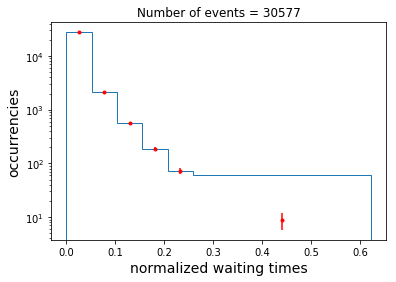

variance of exponent p =  0.022925428648949184
R_max = 0.4097534567396975 * max_distance
5909 events hav been removed (15.71%)

For m = 2.5 and N = 31712 the minimum number of events in the tail required is : 52
Minimum accuracy expected : 0.86


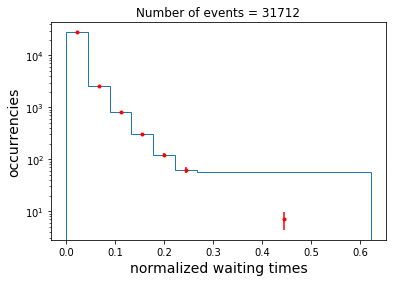

variance of exponent p =  0.02944116755783289
R_max = 0.45712187779232905 * max_distance
4824 events hav been removed (12.82%)

For m = 2.5 and N = 32797 the minimum number of events in the tail required is : 54
Minimum accuracy expected : 0.86


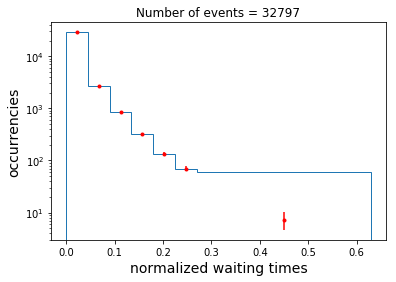

variance of exponent p =  0.030028212841106704
R_max = 0.507080572905716 * max_distance
3765 events hav been removed (10.01%)

For m = 2.5 and N = 33856 the minimum number of events in the tail required is : 55
Minimum accuracy expected : 0.87


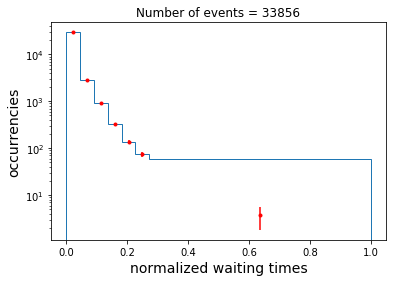

variance of exponent p =  0.020764169073899903
R_max = 0.5596295420798582 * max_distance
2667 events hav been removed (7.09%)

For m = 2.5 and N = 34954 the minimum number of events in the tail required is : 57
Minimum accuracy expected : 0.87


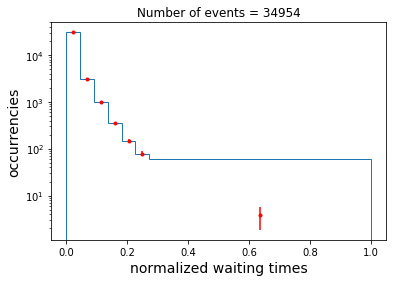

variance of exponent p =  0.023260109342721904
R_max = 0.6147687853147554 * max_distance
1941 events hav been removed (5.16%)

For m = 2.5 and N = 35680 the minimum number of events in the tail required is : 58
Minimum accuracy expected : 0.87


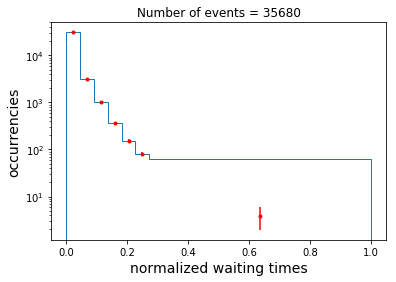

variance of exponent p =  0.02439496054313986
R_max = 0.672498302610408 * max_distance
1384 events hav been removed (3.68%)

For m = 2.5 and N = 36237 the minimum number of events in the tail required is : 59
Minimum accuracy expected : 0.87


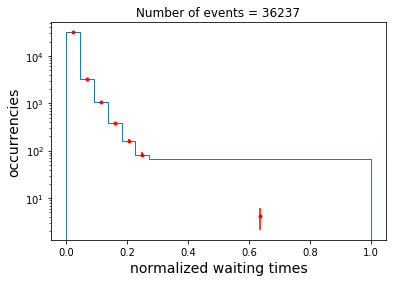

variance of exponent p =  0.024247307060241384
R_max = 0.7328180939668159 * max_distance
630 events hav been removed (1.67%)

For m = 2.5 and N = 36991 the minimum number of events in the tail required is : 60
Minimum accuracy expected : 0.87


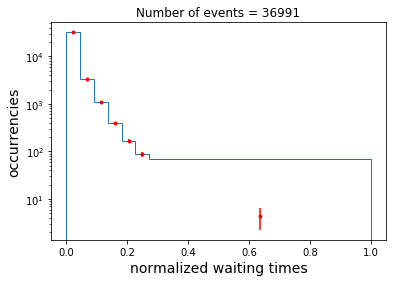

variance of exponent p =  0.02536778321670775
R_max = 0.7957281593839789 * max_distance
272 events hav been removed (0.72%)

For m = 2.5 and N = 37349 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


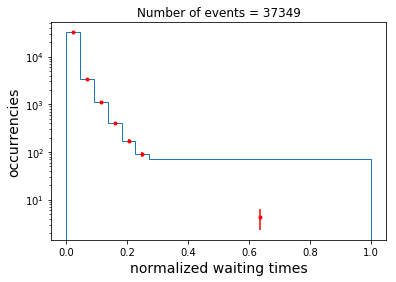

variance of exponent p =  0.025529003071525728
R_max = 0.8612284988618972 * max_distance
77 events hav been removed (0.2%)

For m = 2.5 and N = 37544 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


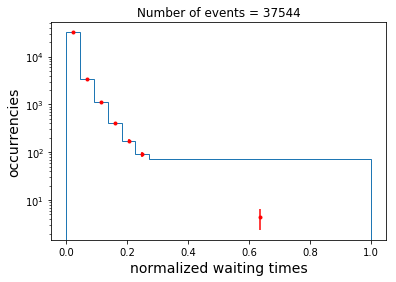

variance of exponent p =  0.025619286908353855
R_max = 0.9293191124005712 * max_distance
14 events hav been removed (0.04%)

For m = 2.5 and N = 37607 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87


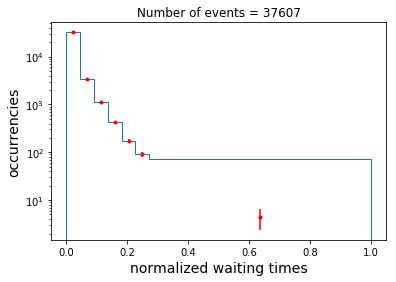

variance of exponent p =  0.025808301557763542
R_max = 1.0 * max_distance
0 events hav been removed (0.0%)

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87


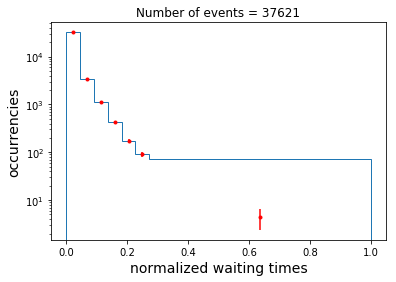

variance of exponent p =  0.025888847400364116
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 0.1 * max_distance
5126 events hav been removed (44.74%)

For m = 3.0 and N = 6331 the minimum number of events in the tail required is : 17
Minimum accuracy expected : 0.76


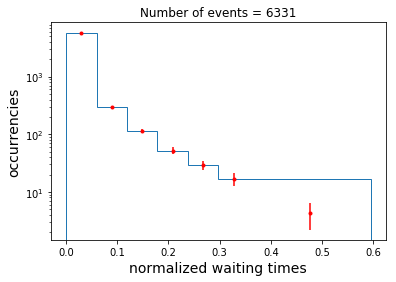

variance of exponent p =  0.008852379867962794
R_max = 0.12405595450583427 * max_distance
4739 events hav been removed (41.36%)

For m = 3.0 and N = 6718 the minimum number of events in the tail required is : 18
Minimum accuracy expected : 0.76


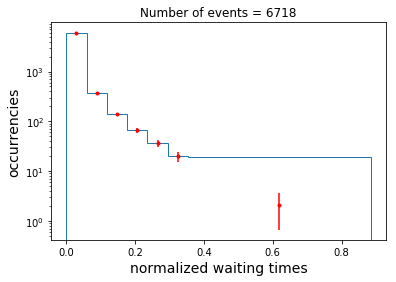

variance of exponent p =  0.014140514348077794
R_max = 0.15070218307242375 * max_distance
4423 events hav been removed (38.6%)

For m = 3.0 and N = 7034 the minimum number of events in the tail required is : 19
Minimum accuracy expected : 0.77


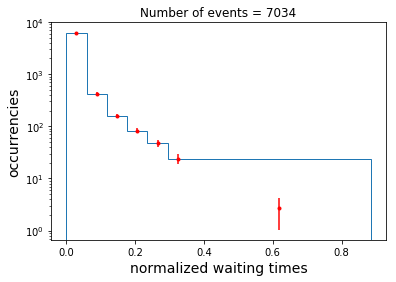

variance of exponent p =  0.016371320214496148
R_max = 0.17993868569976854 * max_distance
3978 events hav been removed (34.72%)

For m = 3.0 and N = 7479 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 7479 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78


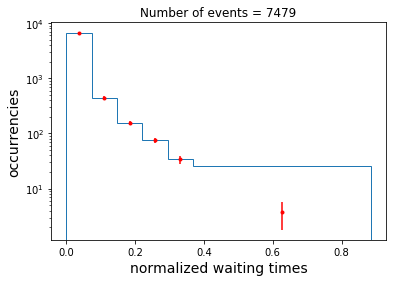

variance of exponent p =  0.019004763785228758
R_max = 0.21176546238786859 * max_distance
3505 events hav been removed (30.59%)

For m = 3.0 and N = 7952 the minimum number of events in the tail required is : 21
Minimum accuracy expected : 0.78


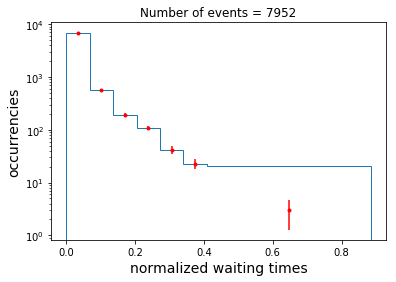

variance of exponent p =  0.025915288239927378
R_max = 0.24618251313672385 * max_distance
3086 events hav been removed (26.93%)

For m = 3.0 and N = 8371 the minimum number of events in the tail required is : 22
Minimum accuracy expected : 0.79


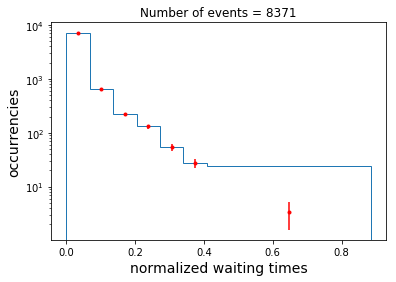

variance of exponent p =  0.031765469645605254
R_max = 0.28318983794633446 * max_distance
2674 events hav been removed (23.34%)

For m = 3.0 and N = 8783 the minimum number of events in the tail required is : 23
Minimum accuracy expected : 0.79


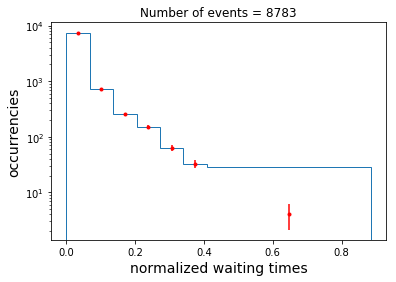

variance of exponent p =  0.03276558508154748
R_max = 0.32278743681670025 * max_distance
2313 events hav been removed (20.19%)

For m = 3.0 and N = 9144 the minimum number of events in the tail required is : 24
Minimum accuracy expected : 0.8


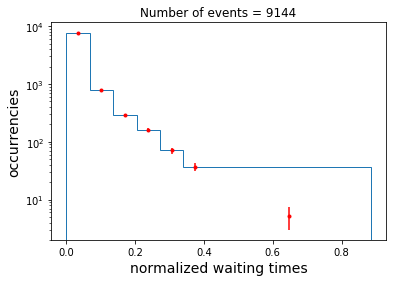

variance of exponent p =  0.026490123855062536
R_max = 0.3649753097478212 * max_distance
1959 events hav been removed (17.1%)

For m = 3.0 and N = 9498 the minimum number of events in the tail required is : 25
Minimum accuracy expected : 0.8


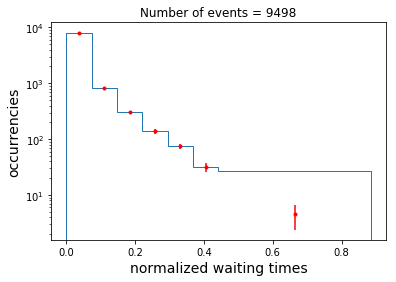

variance of exponent p =  0.03830260942867574
R_max = 0.4097534567396975 * max_distance
1573 events hav been removed (13.73%)

For m = 3.0 and N = 9884 the minimum number of events in the tail required is : 26
Minimum accuracy expected : 0.8


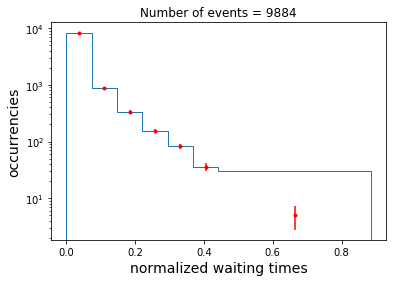

variance of exponent p =  0.039454615124467164
R_max = 0.45712187779232905 * max_distance
1213 events hav been removed (10.59%)

For m = 3.0 and N = 10244 the minimum number of events in the tail required is : 27
Minimum accuracy expected : 0.81


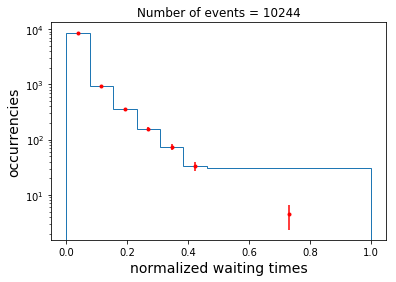

variance of exponent p =  0.0371810418551328
R_max = 0.507080572905716 * max_distance
905 events hav been removed (7.9%)

For m = 3.0 and N = 10552 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81


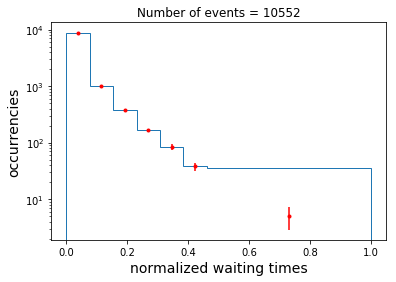

variance of exponent p =  0.035196527057859035
R_max = 0.5596295420798582 * max_distance
643 events hav been removed (5.61%)

For m = 3.0 and N = 10814 the minimum number of events in the tail required is : 29
Minimum accuracy expected : 0.81


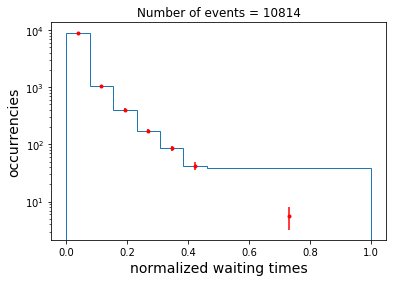

variance of exponent p =  0.03446482529342578
R_max = 0.6147687853147554 * max_distance
391 events hav been removed (3.41%)

For m = 3.0 and N = 11066 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82


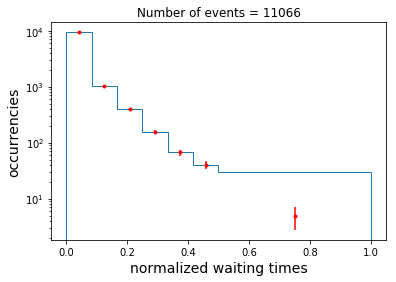

variance of exponent p =  0.039593359024384274
R_max = 0.672498302610408 * max_distance
178 events hav been removed (1.55%)

For m = 3.0 and N = 11279 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82


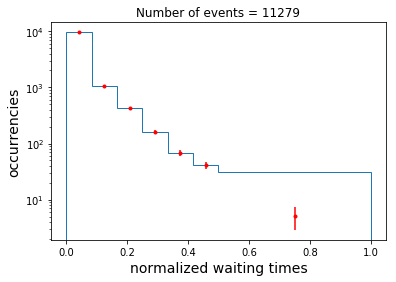

variance of exponent p =  0.04075255439690818
R_max = 0.7328180939668159 * max_distance
64 events hav been removed (0.56%)

For m = 3.0 and N = 11393 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82


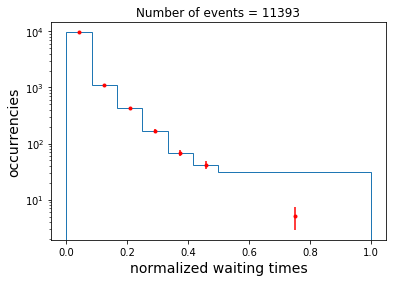

variance of exponent p =  0.04287060793161577
R_max = 0.7957281593839789 * max_distance
20 events hav been removed (0.17%)

For m = 3.0 and N = 11437 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


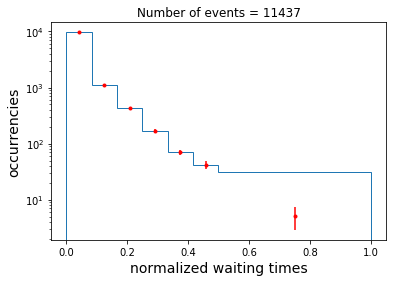

variance of exponent p =  0.04340342335520126
R_max = 0.8612284988618972 * max_distance
7 events hav been removed (0.06%)

For m = 3.0 and N = 11450 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


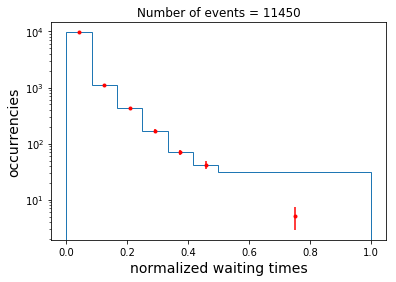

variance of exponent p =  0.04338202986616849
R_max = 0.9293191124005712 * max_distance
4 events hav been removed (0.03%)

For m = 3.0 and N = 11453 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


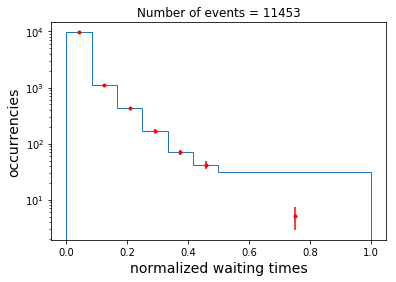

variance of exponent p =  0.04346726073371724
R_max = 1.0 * max_distance
0 events hav been removed (0.0%)

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


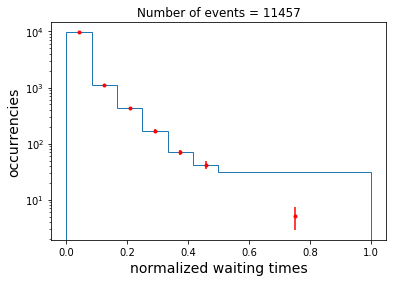

variance of exponent p =  0.043465427632023726
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 0.1 * max_distance
1552 events hav been removed (44.0%)

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


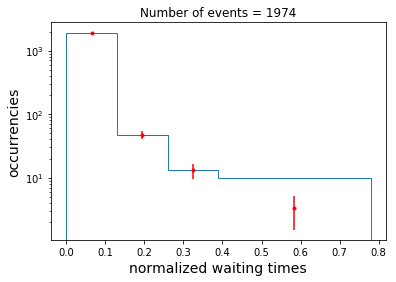

variance of exponent p =  0.03902461964971894
R_max = 0.12405595450583427 * max_distance
1443 events hav been removed (40.91%)

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


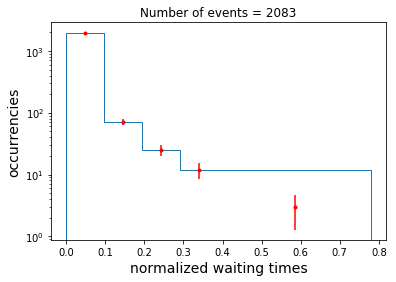

variance of exponent p =  0.013012289822672395
R_max = 0.15070218307242375 * max_distance
1338 events hav been removed (37.94%)

For m = 3.5 and N = 2188 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2188 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 2188 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


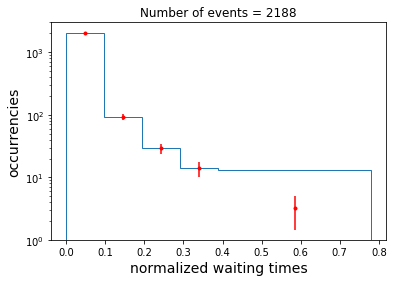

variance of exponent p =  0.004870464799521324
R_max = 0.17993868569976854 * max_distance
1214 events hav been removed (34.42%)

For m = 3.5 and N = 2312 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2312 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 2312 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 3.5 and N = 2312 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


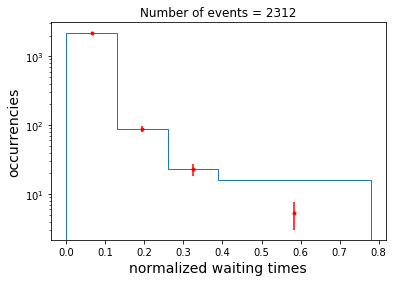

variance of exponent p =  0.006175002998074779
R_max = 0.21176546238786859 * max_distance
1101 events hav been removed (31.22%)

For m = 3.5 and N = 2425 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


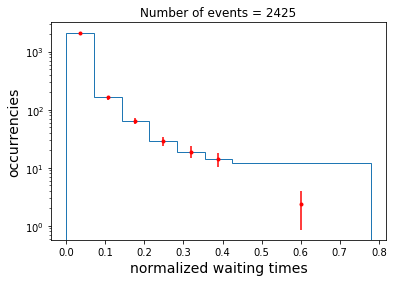

variance of exponent p =  0.014244338687989981
R_max = 0.24618251313672385 * max_distance
960 events hav been removed (27.22%)

For m = 3.5 and N = 2566 the minimum number of events in the tail required is : 11
Minimum accuracy expected : 0.7
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2566 the minimum number of events in the tail required is : 11
Minimum accuracy expected : 0.7


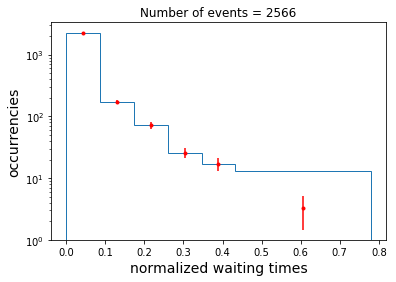

variance of exponent p =  0.016473128434734845
R_max = 0.28318983794633446 * max_distance
824 events hav been removed (23.36%)

For m = 3.5 and N = 2702 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2702 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71


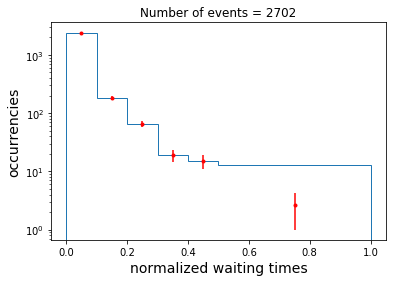

variance of exponent p =  0.012565409486716424
R_max = 0.32278743681670025 * max_distance
720 events hav been removed (20.41%)

For m = 3.5 and N = 2806 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2806 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71


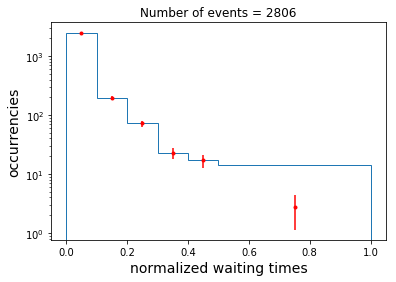

variance of exponent p =  0.013515322286828117
R_max = 0.3649753097478212 * max_distance
609 events hav been removed (17.27%)

For m = 3.5 and N = 2917 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2917 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72


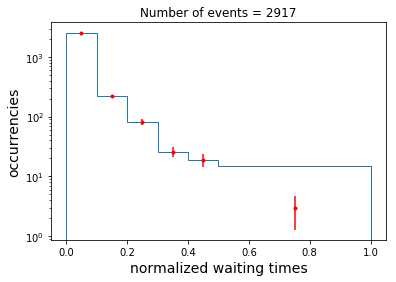

variance of exponent p =  0.016600810009031023
R_max = 0.4097534567396975 * max_distance
485 events hav been removed (13.75%)

For m = 3.5 and N = 3041 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3041 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72


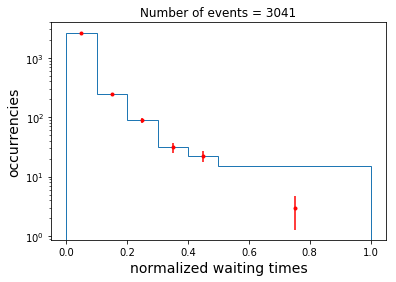

variance of exponent p =  0.023794559676145043
R_max = 0.45712187779232905 * max_distance
389 events hav been removed (11.03%)

For m = 3.5 and N = 3137 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3137 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73


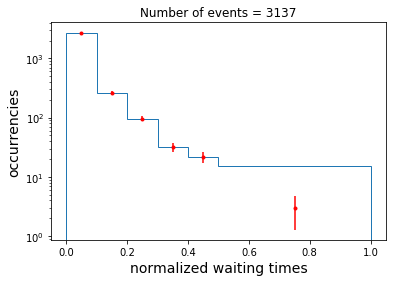

variance of exponent p =  0.026488346717810717
R_max = 0.507080572905716 * max_distance
271 events hav been removed (7.68%)

For m = 3.5 and N = 3255 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3255 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73


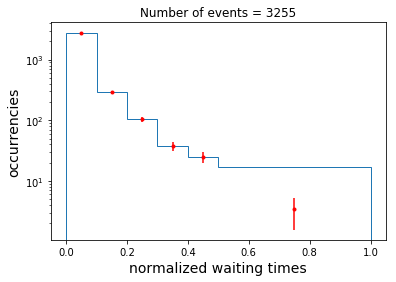

variance of exponent p =  0.027439565464072956
R_max = 0.5596295420798582 * max_distance
198 events hav been removed (5.61%)

For m = 3.5 and N = 3328 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3328 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73


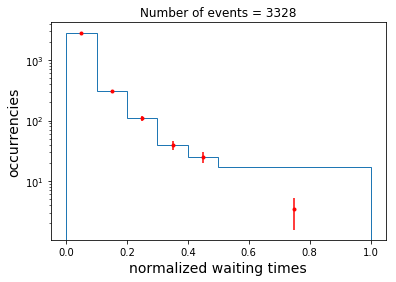

variance of exponent p =  0.030028148061948177
R_max = 0.6147687853147554 * max_distance
136 events hav been removed (3.86%)

For m = 3.5 and N = 3390 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


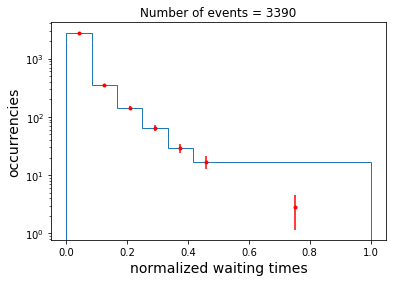

variance of exponent p =  0.02914085064334039
R_max = 0.672498302610408 * max_distance
71 events hav been removed (2.01%)

For m = 3.5 and N = 3455 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3455 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


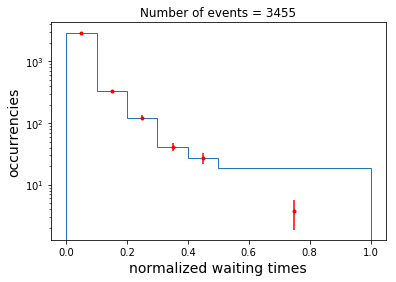

variance of exponent p =  0.030322745933968966
R_max = 0.7328180939668159 * max_distance
37 events hav been removed (1.05%)

For m = 3.5 and N = 3489 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3489 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


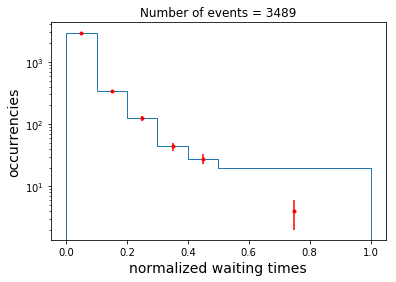

variance of exponent p =  0.0299787549067732
R_max = 0.7957281593839789 * max_distance
17 events hav been removed (0.48%)

For m = 3.5 and N = 3509 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3509 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


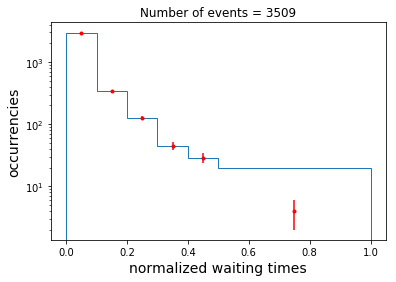

variance of exponent p =  0.0313318870435873
R_max = 0.8612284988618972 * max_distance
9 events hav been removed (0.26%)

For m = 3.5 and N = 3517 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3517 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


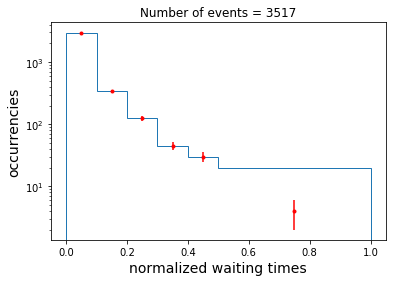

variance of exponent p =  0.03230154974688048
R_max = 0.9293191124005712 * max_distance
5 events hav been removed (0.14%)

For m = 3.5 and N = 3521 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3521 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


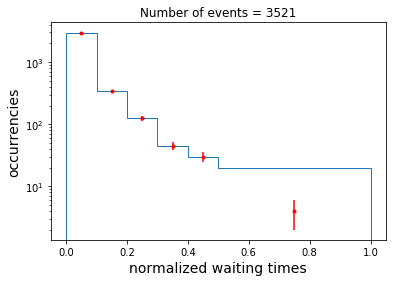

variance of exponent p =  0.03230902714182918
R_max = 1.0 * max_distance
0 events hav been removed (0.0%)

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


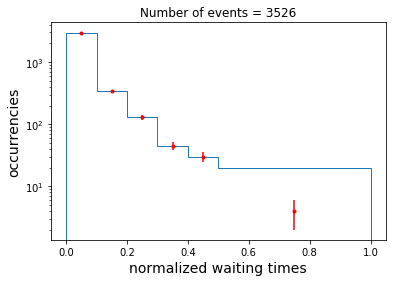

variance of exponent p =  0.0331810913941484
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 0.1 * max_distance
488 events hav been removed (44.36%)

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 

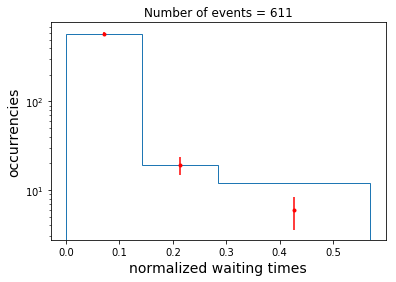

variance of exponent p =  0.15221514107832426
R_max = 0.12405595450583427 * max_distance
449 events hav been removed (40.82%)

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


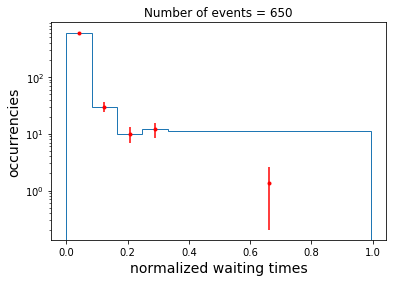

variance of exponent p =  0.04927471637822591
R_max = 0.15070218307242375 * max_distance
415 events hav been removed (37.73%)

For m = 4.0 and N = 684 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 684 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 684 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 684 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


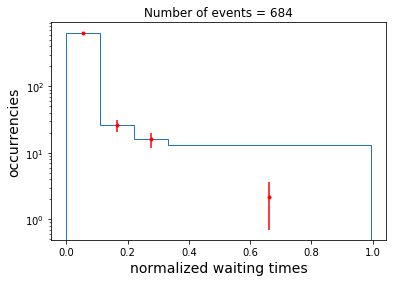

variance of exponent p =  0.05268541075662891
R_max = 0.17993868569976854 * max_distance
368 events hav been removed (33.45%)

For m = 4.0 and N = 731 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 731 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 731 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 731 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


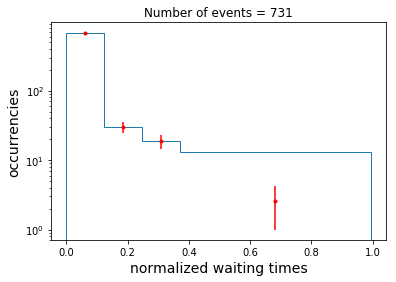

variance of exponent p =  0.048678235738703404
R_max = 0.21176546238786859 * max_distance
332 events hav been removed (30.18%)

For m = 4.0 and N = 767 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 767 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 767 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 767 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


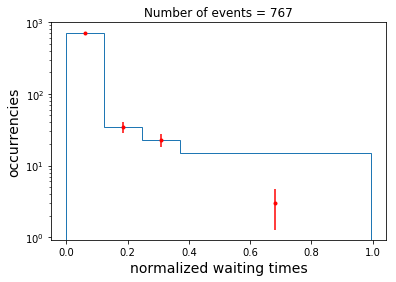

variance of exponent p =  0.05030207453012932
R_max = 0.24618251313672385 * max_distance
304 events hav been removed (27.64%)

For m = 4.0 and N = 795 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 795 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


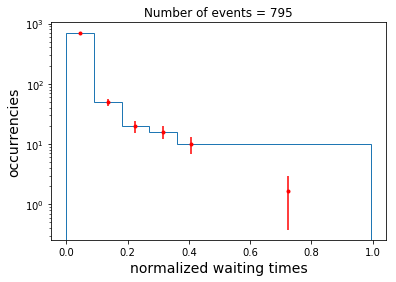

variance of exponent p =  0.022219165238055873
R_max = 0.28318983794633446 * max_distance
269 events hav been removed (24.45%)

For m = 4.0 and N = 830 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 830 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 830 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 830 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


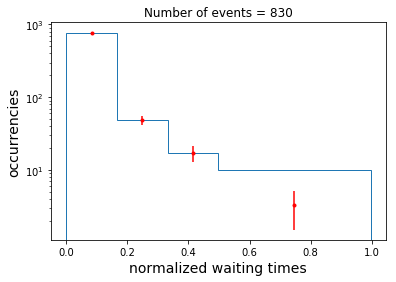

variance of exponent p =  0.004693093147158337
R_max = 0.32278743681670025 * max_distance
216 events hav been removed (19.64%)

For m = 4.0 and N = 883 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 883 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 883 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 883 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


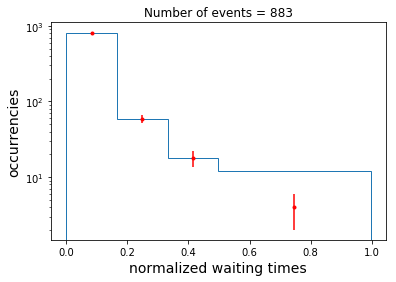

variance of exponent p =  0.000985377374079721
R_max = 0.3649753097478212 * max_distance
179 events hav been removed (16.27%)

For m = 4.0 and N = 920 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 920 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 920 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 920 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


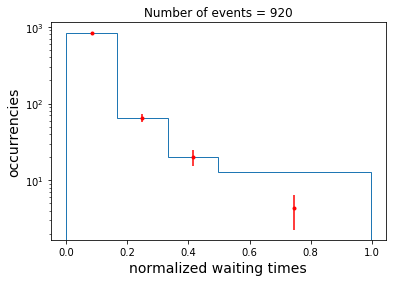

variance of exponent p =  0.002200031371087521
R_max = 0.4097534567396975 * max_distance
136 events hav been removed (12.36%)

For m = 4.0 and N = 963 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 963 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 963 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 963 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


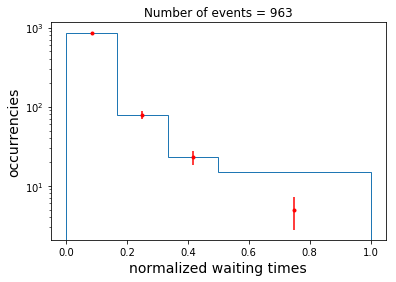

variance of exponent p =  0.005874087598576644
R_max = 0.45712187779232905 * max_distance
117 events hav been removed (10.64%)

For m = 4.0 and N = 982 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 982 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 982 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


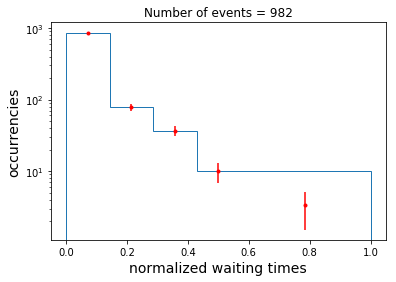

variance of exponent p =  0.023757536720823404
R_max = 0.507080572905716 * max_distance
77 events hav been removed (7.0%)

For m = 4.0 and N = 1022 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1022 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1022 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


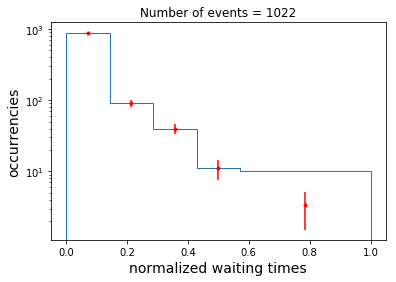

variance of exponent p =  0.028609108293150033
R_max = 0.5596295420798582 * max_distance
50 events hav been removed (4.55%)

For m = 4.0 and N = 1049 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1049 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1049 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


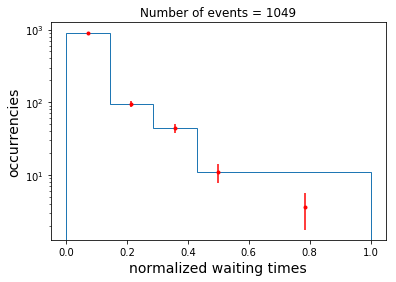

variance of exponent p =  0.03277013552789267
R_max = 0.6147687853147554 * max_distance
34 events hav been removed (3.09%)

For m = 4.0 and N = 1065 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1065 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1065 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


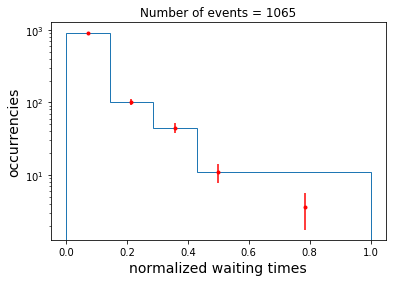

variance of exponent p =  0.03574133880185691
R_max = 0.672498302610408 * max_distance
13 events hav been removed (1.18%)

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


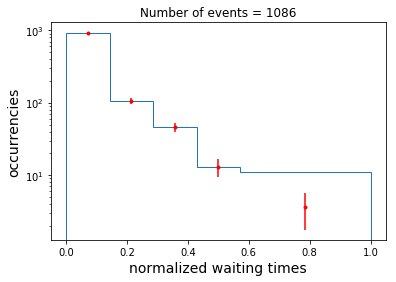

variance of exponent p =  0.034323688413866904
R_max = 0.7328180939668159 * max_distance
7 events hav been removed (0.64%)

For m = 4.0 and N = 1092 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1092 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1092 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


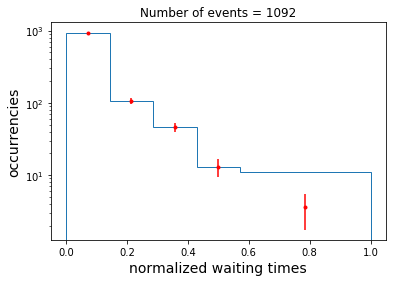

variance of exponent p =  0.03433373656278468
R_max = 0.7957281593839789 * max_distance
4 events hav been removed (0.36%)

For m = 4.0 and N = 1095 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1095 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1095 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


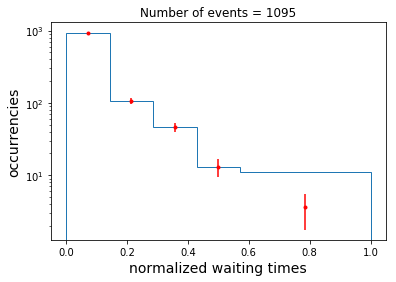

variance of exponent p =  0.03448164178546658
R_max = 0.8612284988618972 * max_distance
3 events hav been removed (0.27%)

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


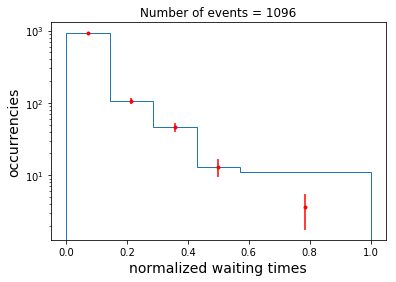

variance of exponent p =  0.03443795232469585
R_max = 0.9293191124005712 * max_distance
1 events hav been removed (0.09%)

For m = 4.0 and N = 1098 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1098 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1098 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


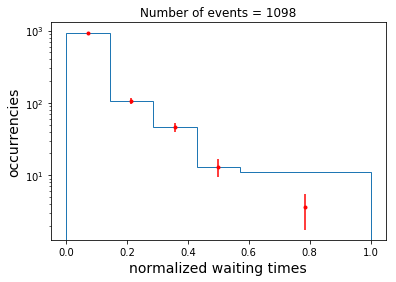

variance of exponent p =  0.03463831378611091
R_max = 1.0 * max_distance
0 events hav been removed (0.0%)

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


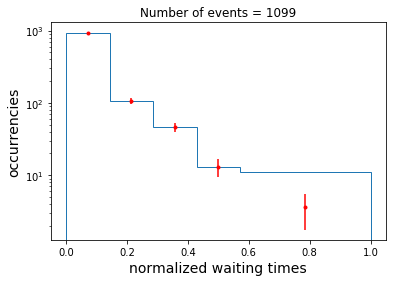

variance of exponent p =  0.0345941595688177
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 0.1 * max_distance
156 events hav been removed (44.44%)

For m = 4.5 and N = 194 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 194 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 194 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 194 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [126]:
ms = ms = np.linspace(2,4.5,6)
R_fractions = 20
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))
R_max = np.zeros(len(ms))

for i in range(len(ms)):
    Ps[i], Qs[i], P_errors[i], R_max[i] = Pm_t_Rcondition_snake (ms[i],R_fractions,df)

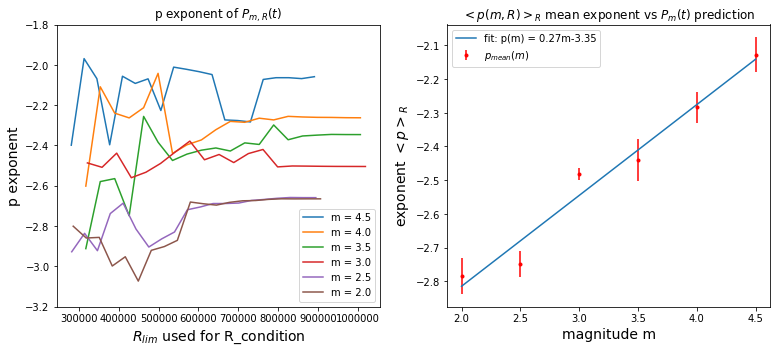

In [28]:
Rs = np.linspace(np.sqrt(0.1),1,R_fractions)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
for i in range(1,len(ms)+1):
    #plt.errorbar(Rs, Ps[-i], yerr = P_errors[-i], label = 'm = {}'.format(ms[-i]))
    ax1.plot(Rs*R_max[-i], Ps[-i], label = 'm = {}'.format(ms[-i]))

ax1.legend(loc = 'lower right')
ax1.set_title('p exponent of $P_{m,R}(t)$')
ax1.set_xlabel('$R_{lim}$ used for R_condition', fontsize = 14)
ax1.set_ylabel('p exponent', fontsize = 14)
ax1.set_ylim(-3.2,-1.8)

ax2.errorbar(ms, Ps.mean(axis = 1), yerr = Ps.std(axis = 1)/np.sqrt(len(ms)), fmt = 'r.', label = '$p_{mean}(m)$')
params, _ = optimize.curve_fit(linear, ms, Ps.mean(axis = 1))
ax2.plot(ms, params[0]*ms+params[1], label = 'fit: p(m) = %.2fm%.2f'%(params[0],params[1]))
ax2.set_title('$<p(m,R)>_R$ mean exponent vs $P_{m}(t)$ prediction')
ax2.set_ylabel('exponent $<p>_R$', fontsize = 14)
ax2.set_xlabel('magnitude m', fontsize = 14)
ax2.legend()

plt.tight_layout()
plt.autoscale(1)
plt.show()


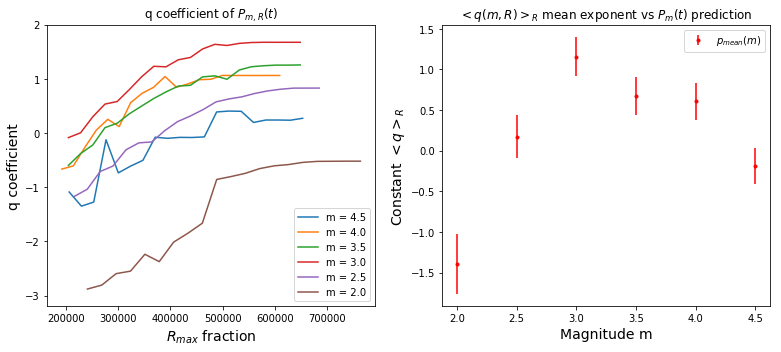

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
for i in range(1,len(ms)+1):
    #plt.errorbar(Rs, Ps[-i], yerr = P_errors[-i], label = 'm = {}'.format(ms[-i]))
    ax1.plot(Rs*R_max[-i], Qs[-i], label = 'm = {}'.format(ms[-i]))

ax1.legend(loc = 'lower right')
ax1.set_title('q coefficient of $P_{m,R}(t)$')
ax1.set_xlabel('$R_{max}$ fraction', fontsize = 14)
ax1.set_ylabel('q coefficient', fontsize = 14)
ax1.set_ylim(-3.2,2)

ax2.errorbar(ms, Qs.mean(axis = 1), yerr = Qs.std(axis = 1)/np.sqrt(len(ms)), fmt = 'r.', label = '$p_{mean}(m)$')
#params, _ = optimize.curve_fit(linear, ms, Qs.mean(axis = 1))
#ax2.plot(ms, params[0]*ms+params[1], label = 'fit: p(m) = %.2fm%.2f'%(params[0],params[1]))
ax2.set_title('$<q(m,R)>_R$ mean exponent vs $P_{m}(t)$ prediction')
ax2.set_ylabel('Constant $<q>_R$', fontsize = 14)
ax2.set_xlabel('Magnitude m', fontsize = 14)
ax2.legend()

plt.tight_layout()
plt.autoscale(1)
plt.show()

# forse inutile perchè q dipende dal numero di dati compresi all'interno del raggio

[2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25
 5.5  5.75 6.  ]


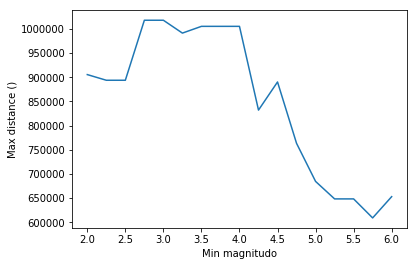

In [30]:
# Finding R_max as a function of m
ms = np.linspace(2,6,17)
print(ms)
R_max = np.zeros(len(ms))
for i in range(len(ms)):
    dfm = df[df['magnitude'] > ms[i]]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    R_max[i] = r.max()
    
plt.plot(ms, R_max)
plt.xlabel("Min magnitudo")
plt.ylabel("Max distance ()")
plt.show()
    

### Metodo dei centri fissati

In [135]:
# Function that computes waiting times with R condition without plotting (fixed m_min) 
# (considering fixed points in space)

def Pm_t_Rcondition_fixed (m, R_fractions, df):
    #print('m = ', m, '\n')
    
    # extract prime events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    dfmp = dfm[dfm['prev_event'] == -1]
    print('\n Number of prime events for this m: ', dfmp.shape)
    
    # needed to compute r.max()
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    
    # needed only for normalization
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = []
    Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2) # R schedule
    print('R_max fractions considered: ', Rs, '\n')
    
    # Repeat plots and fits for each R_max fraction
    for i in range(len(Rs)):
        
        j = 0
        index=0
        m_time_diff = []
        print("\nR_max = "+str(Rs[i])+" * max_distance")  
        
        """
        # Use every prime event to fix centers
        for index, event in dfmp.iterrows():
        
        # track process
        if j==100:
            print('Analizing prime event number', index)
            j = 0
        else:
            j += 1
        """
        
        # find which events happens inside the area AFTER the prime event
        center = np.mean(X,axis=0)
        #center = np.array(dfmp[['x','y','z']])[0]
        positions = np.array(dfm[index:][['x','y','z']])
        R_mask = ( np.linalg.norm(positions-center, axis=1) <= Rs[i]*r.max() )            
        complete_mask = np.concatenate(([False]*index, R_mask )).astype(bool)
        dfmr = dfm[complete_mask]
        print(dfm.shape)
        print(dfmp.shape)
        #dfmr = dfm[complete_mask.astype(bool)]
            
        # compute time intervals between these events and put them in the time_diff vector of this 'm'
        center_time_diff = (np.array(dfmr[1:]['time']) - np.array(dfmr[:-1]['time'])) / time_d.max()
        m_time_diff = np.concatenate((m_time_diff, center_time_diff[center_time_diff>0]))
                                                                 # delete anomalies that cause Δt<0
            
        # computing suitable sizes of bins (same of 'serpentone' from here)
        original_bin_number, bins = select_bin_number_mod(m_time_diff, m = m)
        bin_number = len(bins) - 1

        #n_tailed, bin_extremes, _  = plt.hist(m_time_diff, bins = bins, histtype = 'step')
        n_tailed, bin_extremes, _  = plt.hist(m_time_diff, bins = bins, histtype = 'step', density=True)
        
        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
        delta_bin = bin_extremes[1]-bin_extremes[0]
        area = delta_bin * len(m_time_diff)
         # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))

        # Plot results
        sigma_n = np.sqrt(n/area)
        plt.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
        #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
        plt.yscale('log')
        plt.xlabel('normalized waiting times', fontsize = 14)
        plt.ylabel('occurrencies', fontsize = 14)
        plt.title('Number of events = {}'.format(len(m_time_diff)))
        plt.show()
        
        # linear fit over the log of the entries
        params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
        [p,q] = params1
        var_p = np.diag(cov1)[0]
        print('variance of exponent p = ', var_p)
        plt.close()
        
        #Add parameters in their lists
        ps.append(p)
        qs.append(q)
        p_errors.append(np.sqrt(var_p))
        
    return np.array(ps), np.array(qs), np.array(p_errors), r.max()


 Number of prime events for this m:  (37158, 7)
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 


R_max = 0.1 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 32422 the minimum number of events in the tail required is : 32
Minimum accuracy expected : 0.82


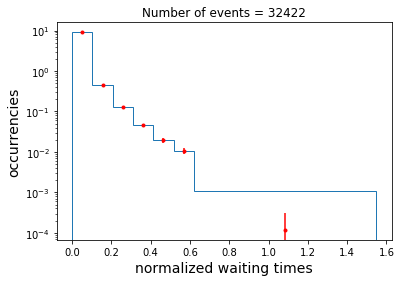

variance of exponent p =  0.15923195299788515

R_max = 0.12405595450583427 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 39978 the minimum number of events in the tail required is : 39
Minimum accuracy expected : 0.84
-> reducing the final number of bins to 6: 

For m = 2.0 and N = 39978 the minimum number of events in the tail required is : 39
Minimum accuracy expected : 0.84


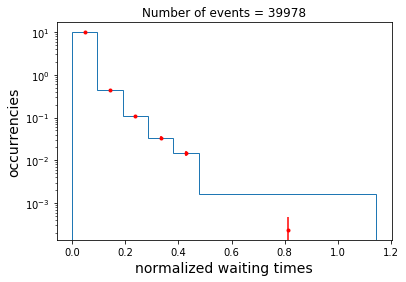

variance of exponent p =  0.15649940485567992

R_max = 0.15070218307242375 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 43679 the minimum number of events in the tail required is : 43
Minimum accuracy expected : 0.85


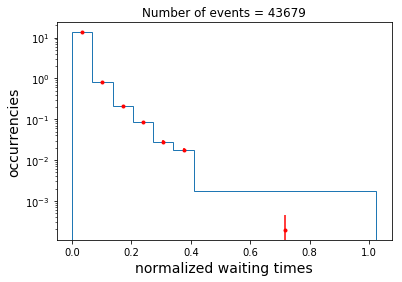

variance of exponent p =  0.16413242642445378

R_max = 0.17993868569976854 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 54255 the minimum number of events in the tail required is : 54
Minimum accuracy expected : 0.86


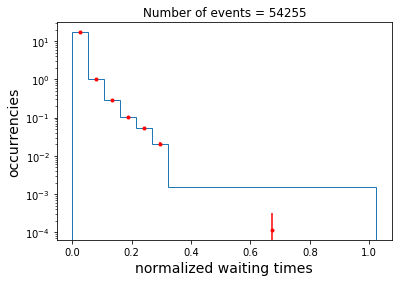

variance of exponent p =  0.18169122727868148

R_max = 0.21176546238786859 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 61905 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


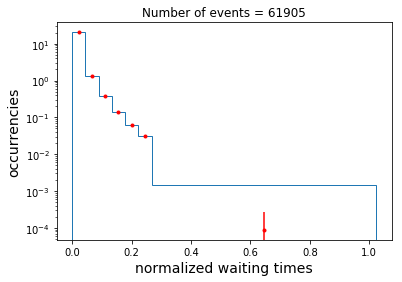

variance of exponent p =  0.17920497015214612

R_max = 0.24618251313672385 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 72008 the minimum number of events in the tail required is : 72
Minimum accuracy expected : 0.88


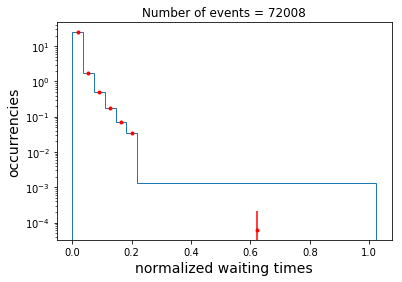

variance of exponent p =  0.1637268233836404

R_max = 0.28318983794633446 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 86768 the minimum number of events in the tail required is : 86
Minimum accuracy expected : 0.89


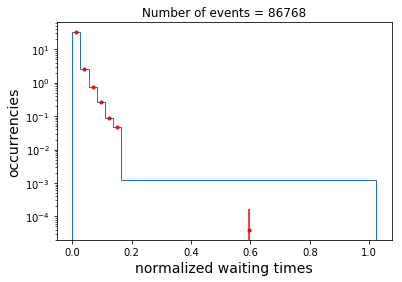

variance of exponent p =  0.14673825934497636

R_max = 0.32278743681670025 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 94695 the minimum number of events in the tail required is : 94
Minimum accuracy expected : 0.9


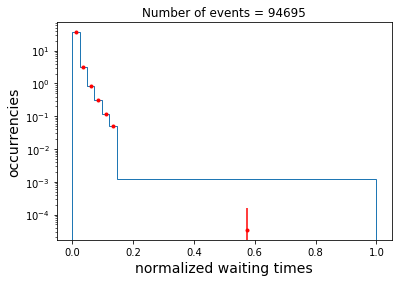

variance of exponent p =  0.14305882339014275

R_max = 0.3649753097478212 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 96336 the minimum number of events in the tail required is : 96
Minimum accuracy expected : 0.9


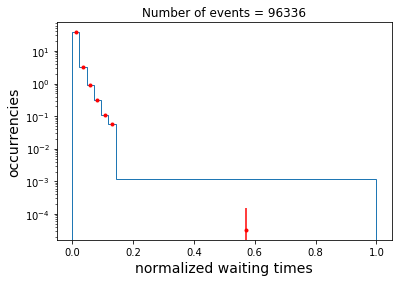

variance of exponent p =  0.14382082179235747

R_max = 0.4097534567396975 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 99078 the minimum number of events in the tail required is : 99
Minimum accuracy expected : 0.9


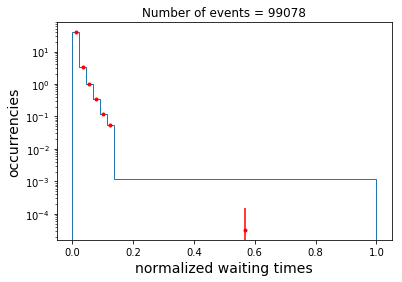

variance of exponent p =  0.1348640600002527

R_max = 0.45712187779232905 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 103944 the minimum number of events in the tail required is : 103
Minimum accuracy expected : 0.9


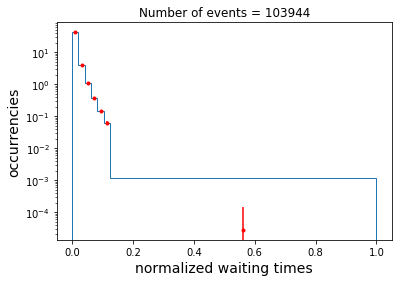

variance of exponent p =  0.13653592184829494

R_max = 0.507080572905716 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 104743 the minimum number of events in the tail required is : 104
Minimum accuracy expected : 0.9


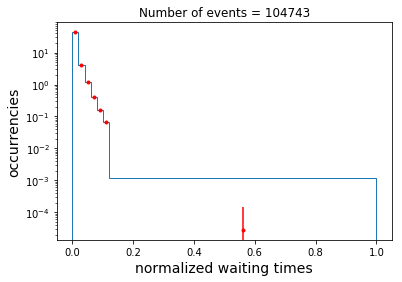

variance of exponent p =  0.1350484119565591

R_max = 0.5596295420798582 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105312 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


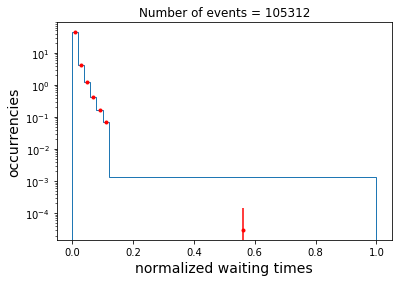

variance of exponent p =  0.12962230433444666

R_max = 0.6147687853147554 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105509 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


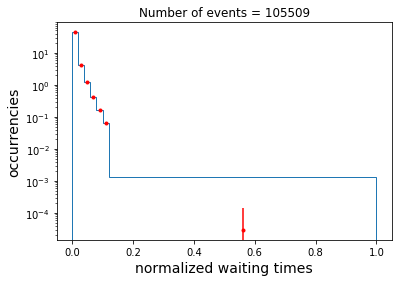

variance of exponent p =  0.1289313777439494

R_max = 0.672498302610408 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105546 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


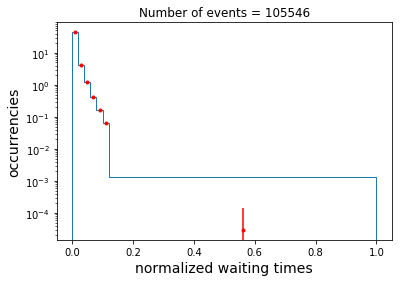

variance of exponent p =  0.12916183149219962

R_max = 0.7328180939668159 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105546 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


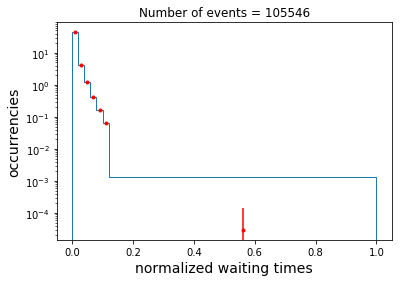

variance of exponent p =  0.12916183149219962

R_max = 0.7957281593839789 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105546 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


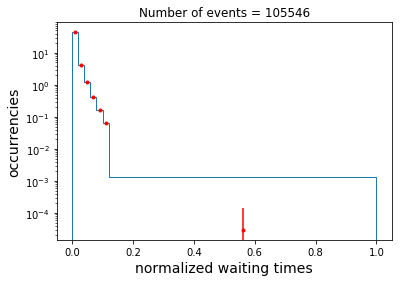

variance of exponent p =  0.12916183149219962

R_max = 0.8612284988618972 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105546 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


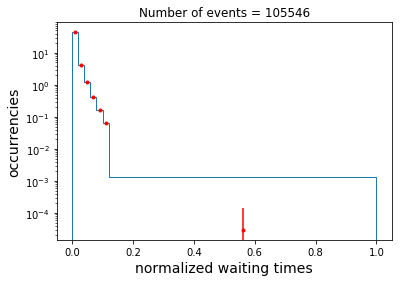

variance of exponent p =  0.12916183149219962

R_max = 0.9293191124005712 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105546 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


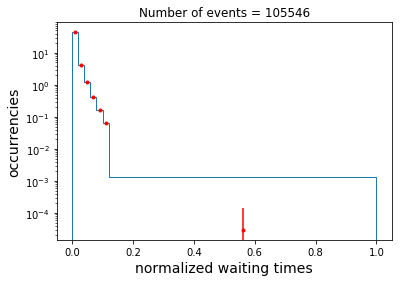

variance of exponent p =  0.12916183149219962

R_max = 1.0 * max_distance
(106198, 7)
(37158, 7)
For m = 2.0 and N = 105546 the minimum number of events in the tail required is : 105
Minimum accuracy expected : 0.9


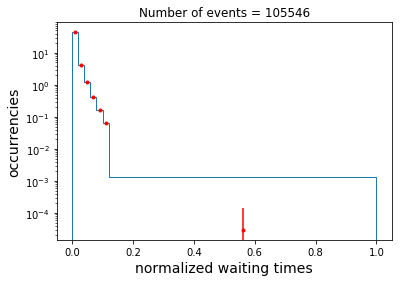

variance of exponent p =  0.12916183149219962

 Number of prime events for this m:  (12483, 7)
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 


R_max = 0.1 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 8127 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 8127 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72


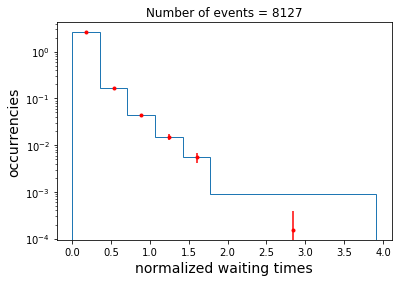

variance of exponent p =  0.1567503177358921

R_max = 0.12405595450583427 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 11085 the minimum number of events in the tail required is : 18
Minimum accuracy expected : 0.76
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 11085 the minimum number of events in the tail required is : 18
Minimum accuracy expected : 0.76


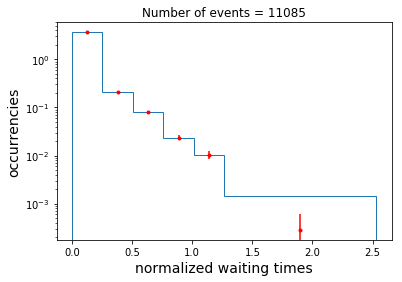

variance of exponent p =  0.19259310138927443

R_max = 0.15070218307242375 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 13450 the minimum number of events in the tail required is : 22
Minimum accuracy expected : 0.79


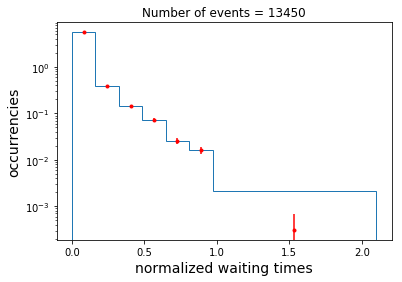

variance of exponent p =  0.17183085265155423

R_max = 0.17993868569976854 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 15892 the minimum number of events in the tail required is : 26
Minimum accuracy expected : 0.8
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 15892 the minimum number of events in the tail required is : 26
Minimum accuracy expected : 0.8


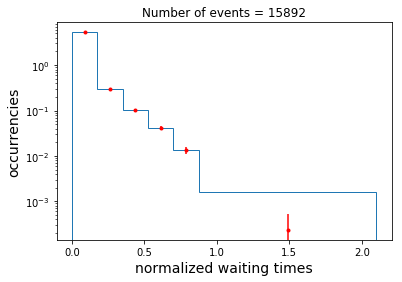

variance of exponent p =  0.20085524202570293

R_max = 0.21176546238786859 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 18710 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82


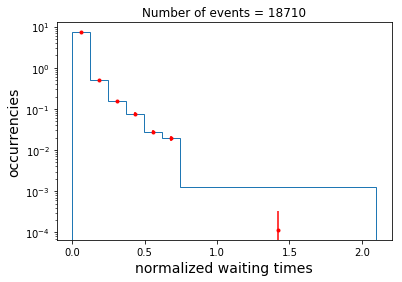

variance of exponent p =  0.20748272304968537

R_max = 0.24618251313672385 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 22321 the minimum number of events in the tail required is : 36
Minimum accuracy expected : 0.83
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 22321 the minimum number of events in the tail required is : 36
Minimum accuracy expected : 0.83


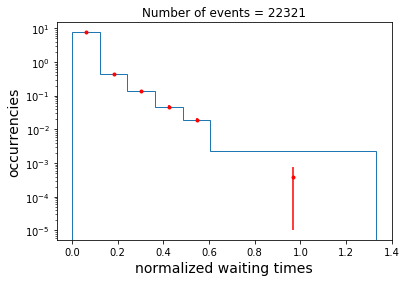

variance of exponent p =  0.19374706833593575

R_max = 0.28318983794633446 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 26881 the minimum number of events in the tail required is : 44
Minimum accuracy expected : 0.85


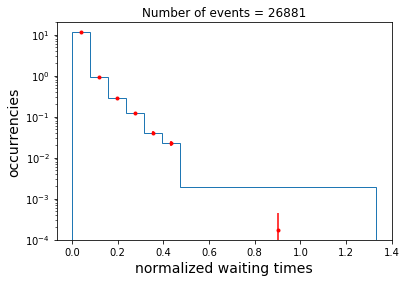

variance of exponent p =  0.19973668368896227

R_max = 0.32278743681670025 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 31399 the minimum number of events in the tail required is : 51
Minimum accuracy expected : 0.86
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 31399 the minimum number of events in the tail required is : 51
Minimum accuracy expected : 0.86


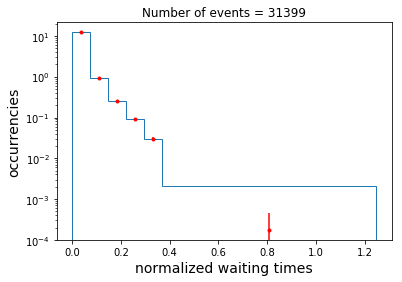

variance of exponent p =  0.2172544017699511

R_max = 0.3649753097478212 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 32323 the minimum number of events in the tail required is : 53
Minimum accuracy expected : 0.86
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 32323 the minimum number of events in the tail required is : 53
Minimum accuracy expected : 0.86


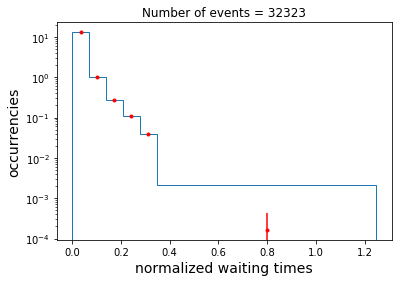

variance of exponent p =  0.22610588053968567

R_max = 0.4097534567396975 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 33648 the minimum number of events in the tail required is : 55
Minimum accuracy expected : 0.87


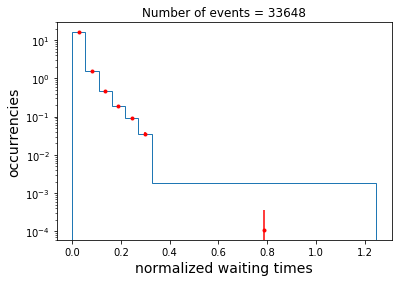

variance of exponent p =  0.22380958758148525

R_max = 0.45712187779232905 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 36089 the minimum number of events in the tail required is : 59
Minimum accuracy expected : 0.87


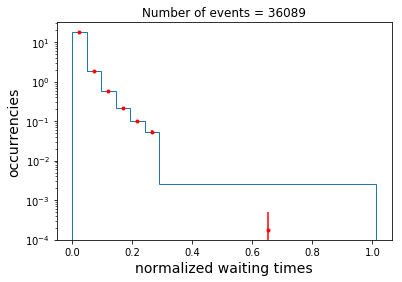

variance of exponent p =  0.23242745139323795

R_max = 0.507080572905716 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 36760 the minimum number of events in the tail required is : 60
Minimum accuracy expected : 0.87


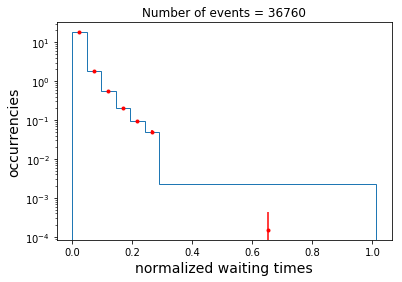

variance of exponent p =  0.2393189472041076

R_max = 0.5596295420798582 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37205 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


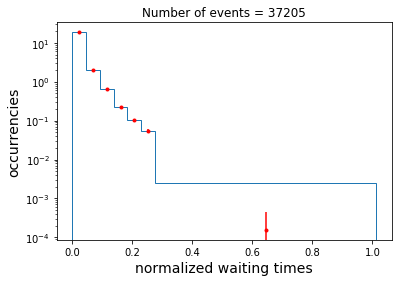

variance of exponent p =  0.23491360904003095

R_max = 0.6147687853147554 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37404 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


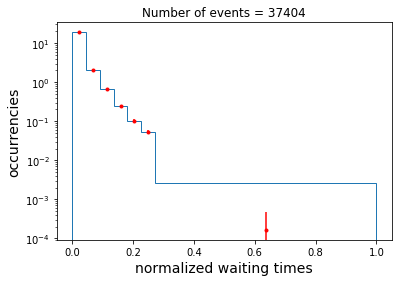

variance of exponent p =  0.23078346733610383

R_max = 0.672498302610408 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37440 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


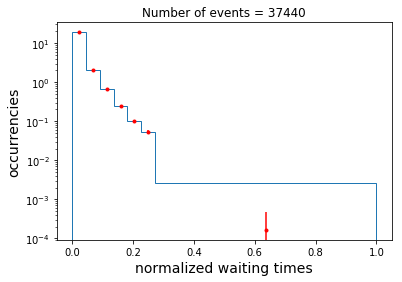

variance of exponent p =  0.23013547743427765

R_max = 0.7328180939668159 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37440 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


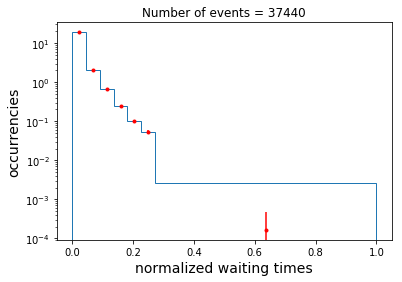

variance of exponent p =  0.23013547743427765

R_max = 0.7957281593839789 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37440 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


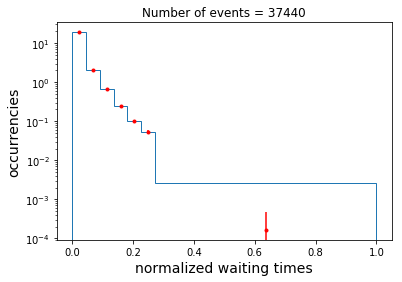

variance of exponent p =  0.23013547743427765

R_max = 0.8612284988618972 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37440 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


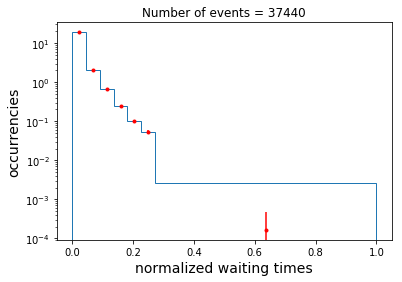

variance of exponent p =  0.23013547743427765

R_max = 0.9293191124005712 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37440 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


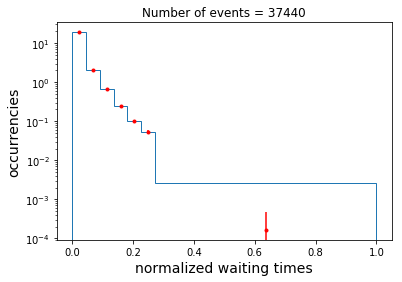

variance of exponent p =  0.23013547743427765

R_max = 1.0 * max_distance
(37622, 7)
(12483, 7)
For m = 2.5 and N = 37440 the minimum number of events in the tail required is : 61
Minimum accuracy expected : 0.87


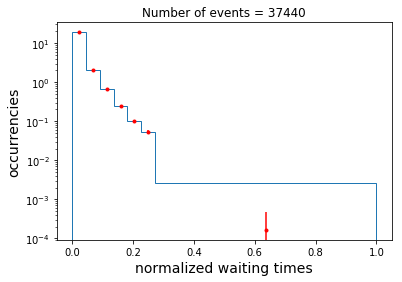

variance of exponent p =  0.23013547743427765

 Number of prime events for this m:  (3568, 7)
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 


R_max = 0.1 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 2698 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 2698 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


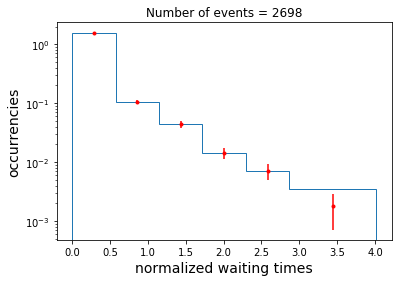

variance of exponent p =  0.03205539085916212

R_max = 0.12405595450583427 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 3231 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 3231 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.0 and N = 3231 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


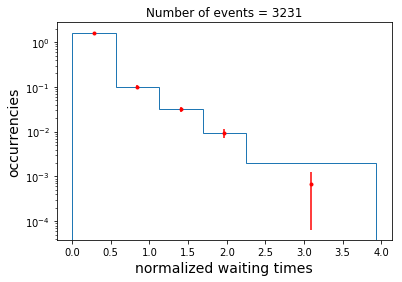

variance of exponent p =  0.13806476925080724

R_max = 0.15070218307242375 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 4074 the minimum number of events in the tail required is : 11
Minimum accuracy expected : 0.7
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 4074 the minimum number of events in the tail required is : 11
Minimum accuracy expected : 0.7


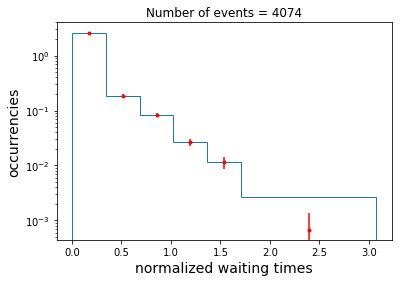

variance of exponent p =  0.142906848909487

R_max = 0.17993868569976854 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 4777 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 4777 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71


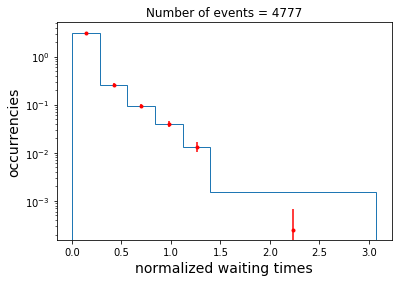

variance of exponent p =  0.26220844911310953

R_max = 0.21176546238786859 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 6017 the minimum number of events in the tail required is : 16
Minimum accuracy expected : 0.75


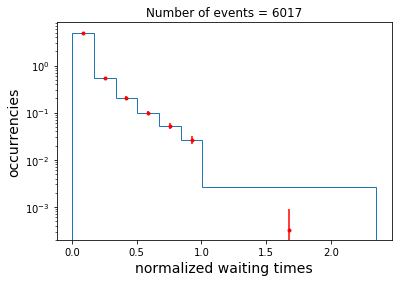

variance of exponent p =  0.23445776926498912

R_max = 0.24618251313672385 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 7161 the minimum number of events in the tail required is : 19
Minimum accuracy expected : 0.77


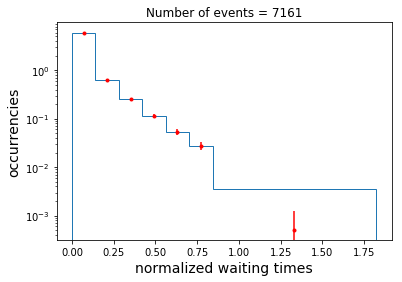

variance of exponent p =  0.20849031268725163

R_max = 0.28318983794633446 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 8871 the minimum number of events in the tail required is : 24
Minimum accuracy expected : 0.8


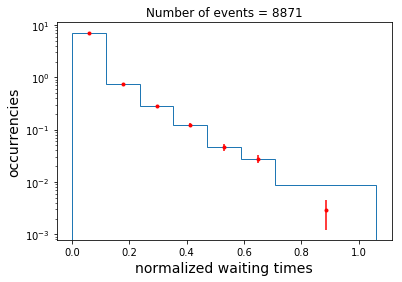

variance of exponent p =  0.0936597162096809

R_max = 0.32278743681670025 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 9322 the minimum number of events in the tail required is : 25
Minimum accuracy expected : 0.8
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 9322 the minimum number of events in the tail required is : 25
Minimum accuracy expected : 0.8


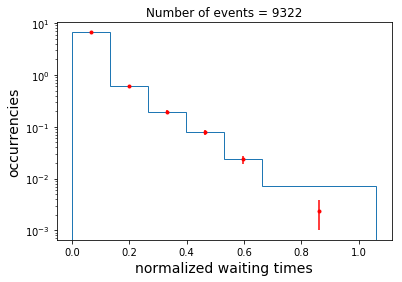

variance of exponent p =  0.13279238005031638

R_max = 0.3649753097478212 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 10019 the minimum number of events in the tail required is : 27
Minimum accuracy expected : 0.81
-> reducing the final number of bins to 6: 

For m = 3.0 and N = 10019 the minimum number of events in the tail required is : 27
Minimum accuracy expected : 0.81
-> reducing the final number of bins to 5: 

For m = 3.0 and N = 10019 the minimum number of events in the tail required is : 27
Minimum accuracy expected : 0.81


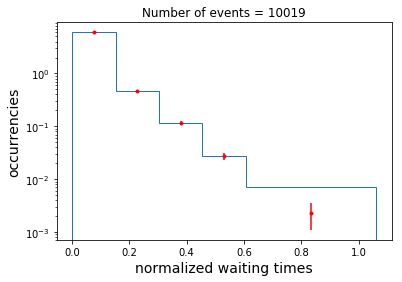

variance of exponent p =  0.1504400210848776

R_max = 0.4097534567396975 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11027 the minimum number of events in the tail required is : 29
Minimum accuracy expected : 0.81


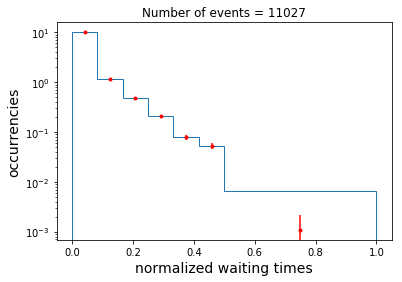

variance of exponent p =  0.21095080963346202

R_max = 0.45712187779232905 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11173 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82


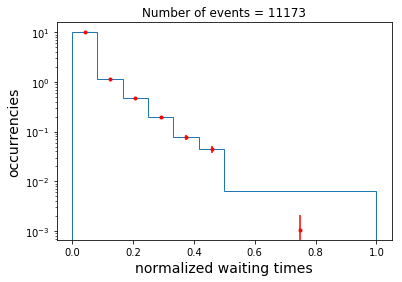

variance of exponent p =  0.20459795083757512

R_max = 0.507080572905716 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11362 the minimum number of events in the tail required is : 30
Minimum accuracy expected : 0.82


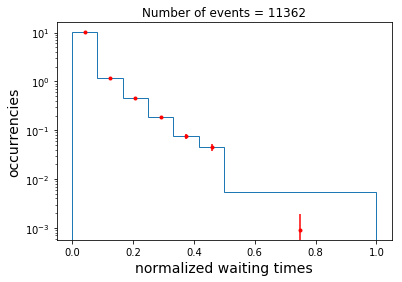

variance of exponent p =  0.21690166362006336

R_max = 0.5596295420798582 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11418 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


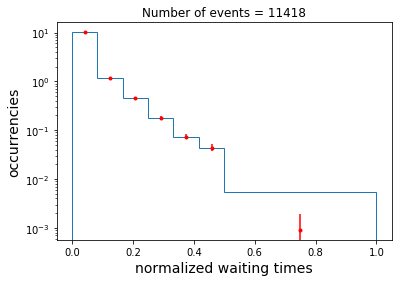

variance of exponent p =  0.21411288517601237

R_max = 0.6147687853147554 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


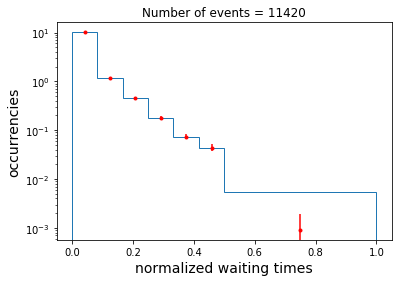

variance of exponent p =  0.2140996167951635

R_max = 0.672498302610408 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


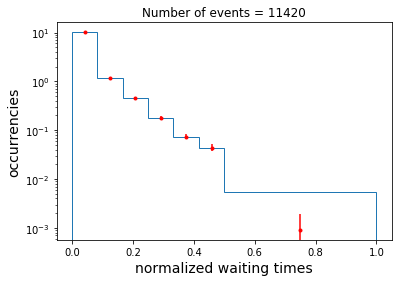

variance of exponent p =  0.2140996167951635

R_max = 0.7328180939668159 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


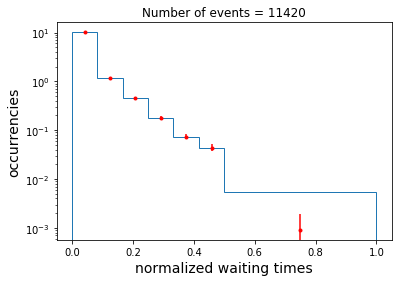

variance of exponent p =  0.2140996167951635

R_max = 0.7957281593839789 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


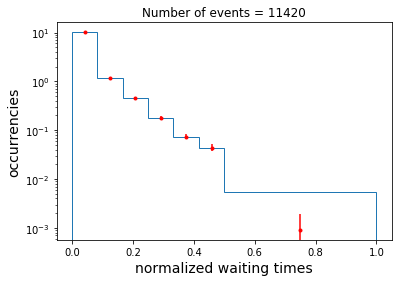

variance of exponent p =  0.2140996167951635

R_max = 0.8612284988618972 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


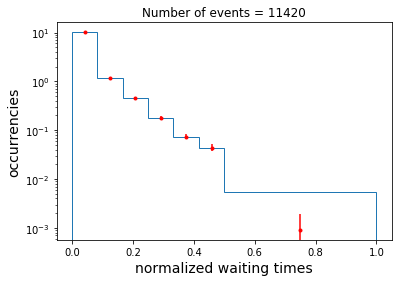

variance of exponent p =  0.2140996167951635

R_max = 0.9293191124005712 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


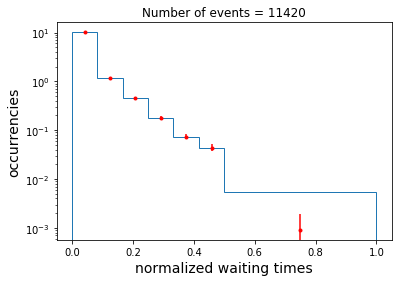

variance of exponent p =  0.2140996167951635

R_max = 1.0 * max_distance
(11458, 7)
(3568, 7)
For m = 3.0 and N = 11420 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


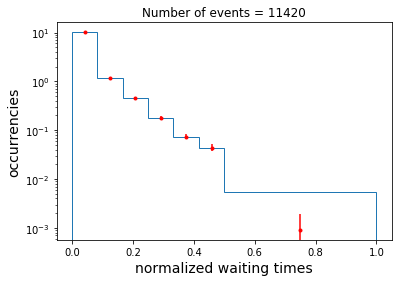

variance of exponent p =  0.2140996167951635

 Number of prime events for this m:  (994, 7)
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 


R_max = 0.1 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 863 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


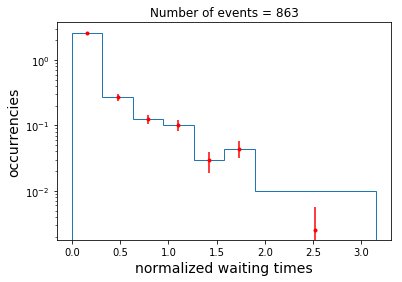

variance of exponent p =  0.10800160499360902

R_max = 0.12405595450583427 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 1090 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 1090 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 1090 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


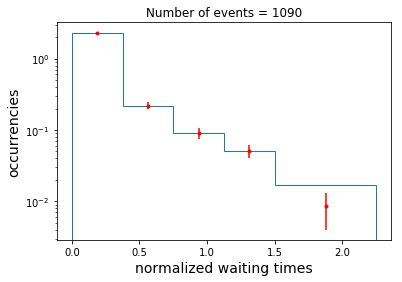

variance of exponent p =  0.060272135212185426

R_max = 0.15070218307242375 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 1335 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


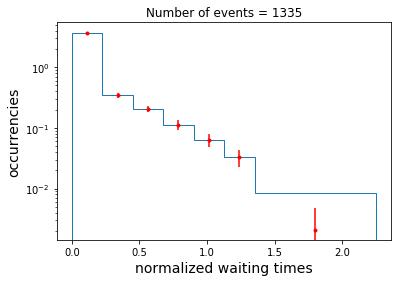

variance of exponent p =  0.13524180960211307

R_max = 0.17993868569976854 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 1529 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


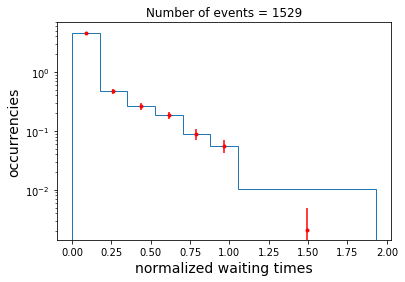

variance of exponent p =  0.17085286336753092

R_max = 0.21176546238786859 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 1906 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 1906 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 1906 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


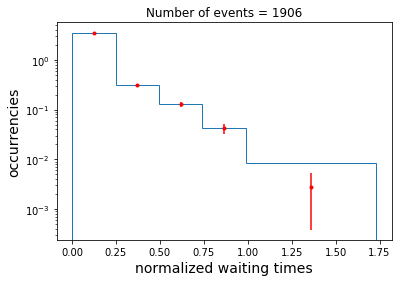

variance of exponent p =  0.18092830760058953

R_max = 0.24618251313672385 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 2125 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2125 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 2125 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


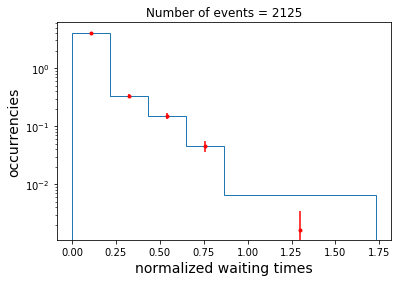

variance of exponent p =  0.2524458714074216

R_max = 0.28318983794633446 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 2617 the minimum number of events in the tail required is : 11
Minimum accuracy expected : 0.7


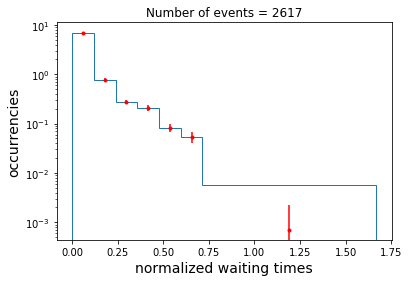

variance of exponent p =  0.22678659356295172

R_max = 0.32278743681670025 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 2805 the minimum number of events in the tail required is : 12
Minimum accuracy expected : 0.71


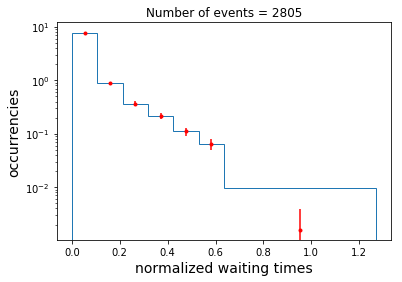

variance of exponent p =  0.19130688123927791

R_max = 0.3649753097478212 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3063 the minimum number of events in the tail required is : 13
Minimum accuracy expected : 0.72


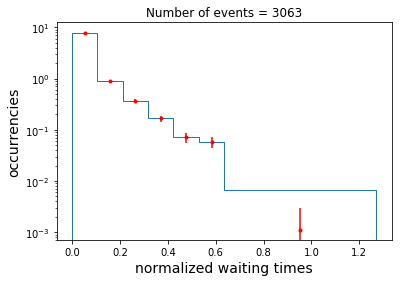

variance of exponent p =  0.19861334533846864

R_max = 0.4097534567396975 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3371 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


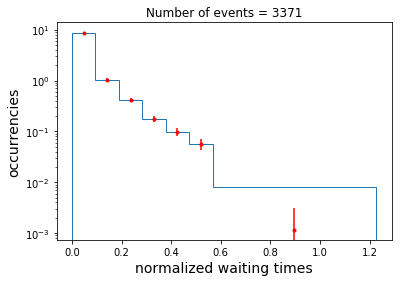

variance of exponent p =  0.18533124725113204

R_max = 0.45712187779232905 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3416 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3416 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


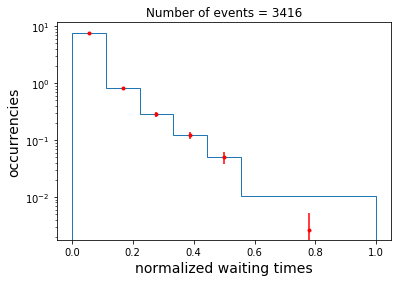

variance of exponent p =  0.16841589560742184

R_max = 0.507080572905716 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3484 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3484 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


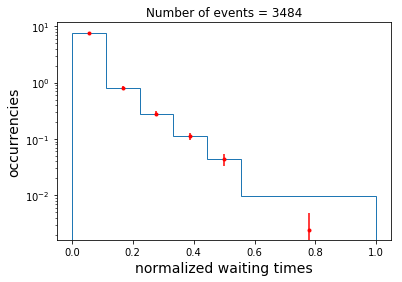

variance of exponent p =  0.16686137312343846

R_max = 0.5596295420798582 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3514 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3514 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


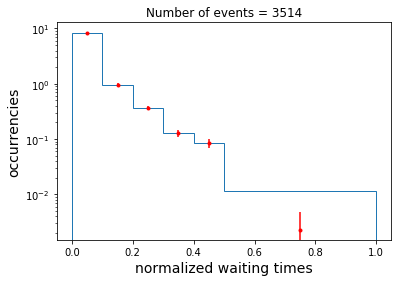

variance of exponent p =  0.21027476930169145

R_max = 0.6147687853147554 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


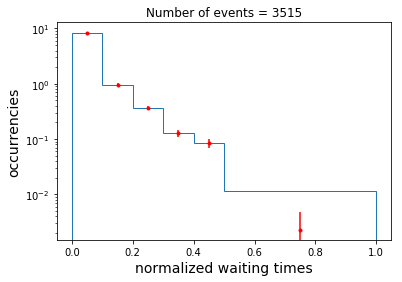

variance of exponent p =  0.21025018803356416

R_max = 0.672498302610408 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


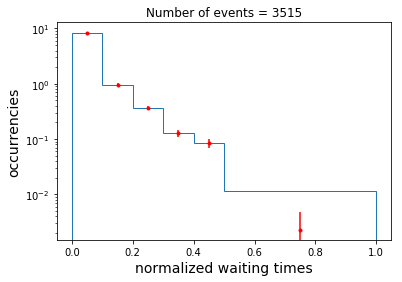

variance of exponent p =  0.21025018803356416

R_max = 0.7328180939668159 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


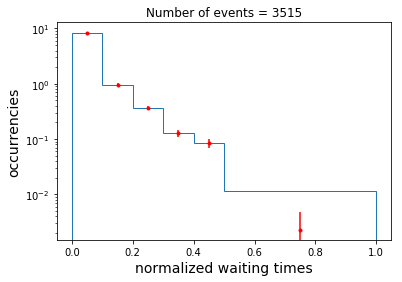

variance of exponent p =  0.21025018803356416

R_max = 0.7957281593839789 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


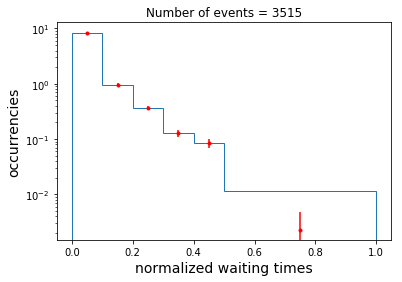

variance of exponent p =  0.21025018803356416

R_max = 0.8612284988618972 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


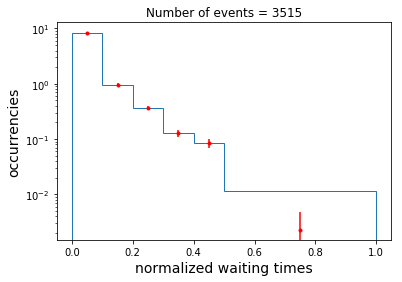

variance of exponent p =  0.21025018803356416

R_max = 0.9293191124005712 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


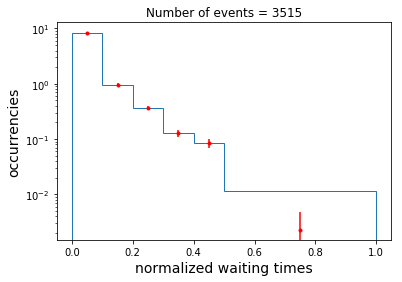

variance of exponent p =  0.21025018803356416

R_max = 1.0 * max_distance
(3527, 7)
(994, 7)
For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3515 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


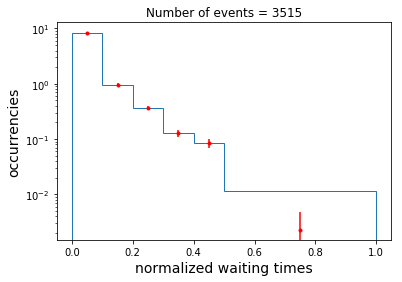

variance of exponent p =  0.21025018803356416

 Number of prime events for this m:  (301, 7)
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 


R_max = 0.1 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducin

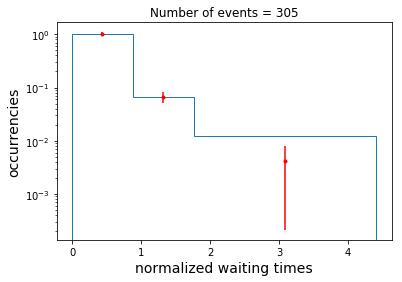

variance of exponent p =  0.0508295683536054

R_max = 0.12405595450583427 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 363 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 363 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 363 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 363 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


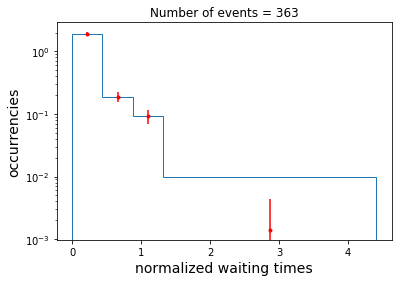

variance of exponent p =  0.22693572378615795

R_max = 0.15070218307242375 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 451 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 451 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 451 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 451 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


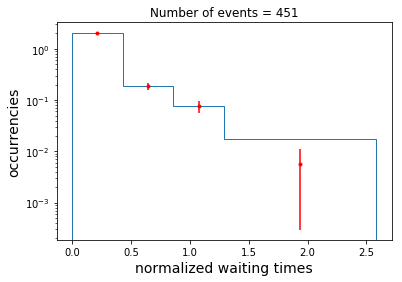

variance of exponent p =  0.13487503605313644

R_max = 0.17993868569976854 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 510 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 510 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 510 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


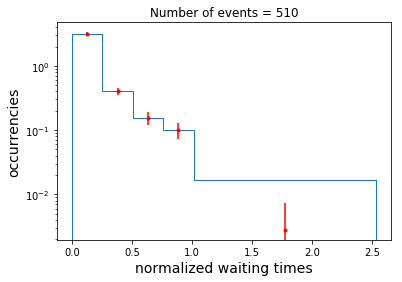

variance of exponent p =  0.19068674775766514

R_max = 0.21176546238786859 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 630 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 630 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 630 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


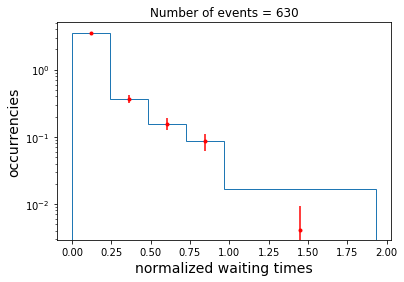

variance of exponent p =  0.17682747011459574

R_max = 0.24618251313672385 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 685 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 685 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 685 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


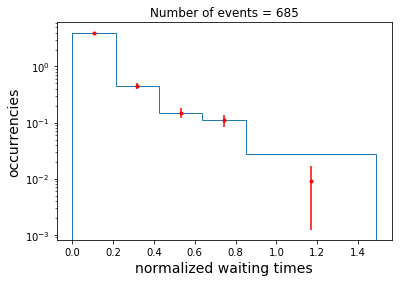

variance of exponent p =  0.11494931771026878

R_max = 0.28318983794633446 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 834 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 834 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 834 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 834 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


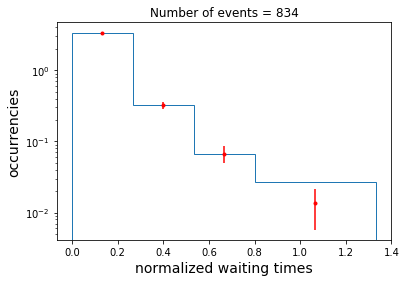

variance of exponent p =  0.05126595441982988

R_max = 0.32278743681670025 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 888 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 888 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 888 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


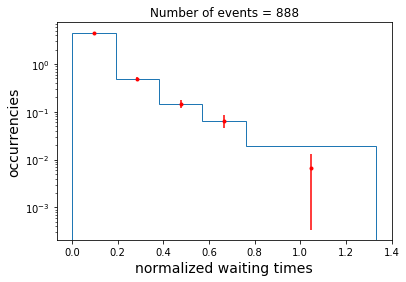

variance of exponent p =  0.09967425457216432

R_max = 0.3649753097478212 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 969 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


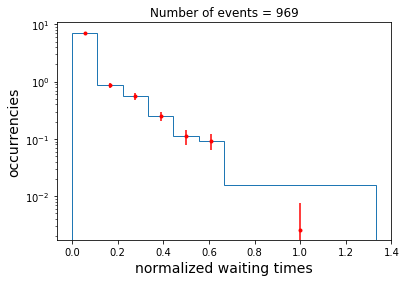

variance of exponent p =  0.17662701631079525

R_max = 0.4097534567396975 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1055 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1055 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


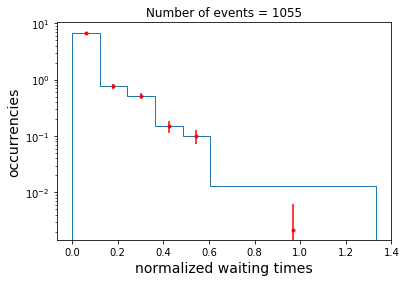

variance of exponent p =  0.24823223195086067

R_max = 0.45712187779232905 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1069 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1069 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


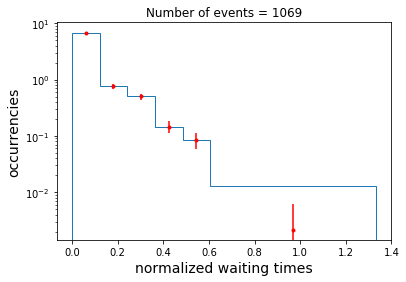

variance of exponent p =  0.23345839469712573

R_max = 0.507080572905716 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1087 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1087 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1087 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


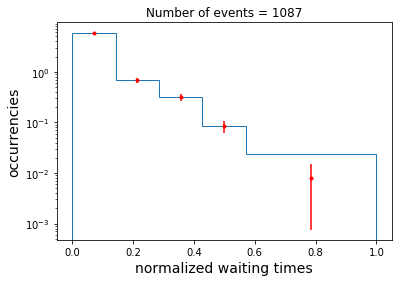

variance of exponent p =  0.17067862279238014

R_max = 0.5596295420798582 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


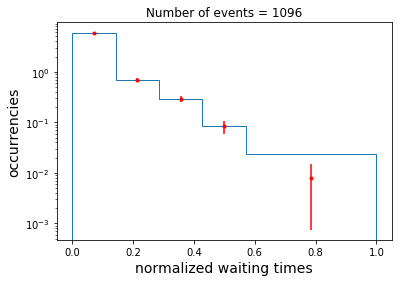

variance of exponent p =  0.1618357686696805

R_max = 0.6147687853147554 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


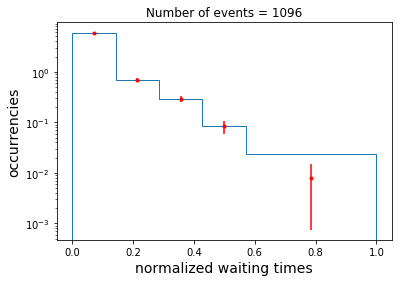

variance of exponent p =  0.1618357686696805

R_max = 0.672498302610408 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


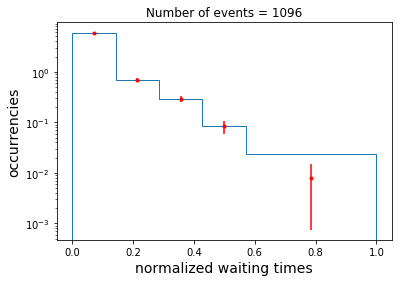

variance of exponent p =  0.1618357686696805

R_max = 0.7328180939668159 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


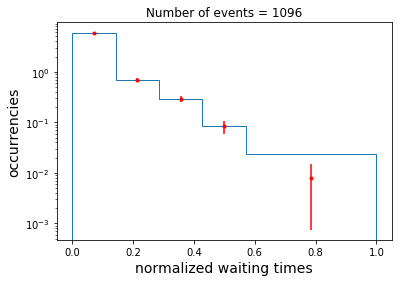

variance of exponent p =  0.1618357686696805

R_max = 0.7957281593839789 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


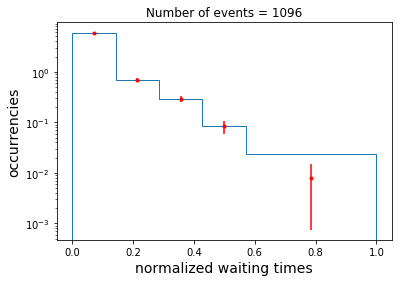

variance of exponent p =  0.1618357686696805

R_max = 0.8612284988618972 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


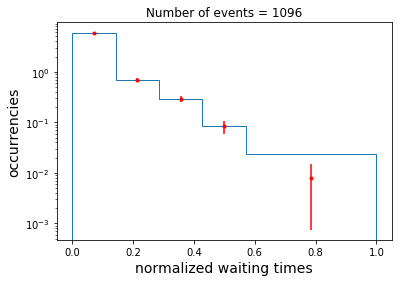

variance of exponent p =  0.1618357686696805

R_max = 0.9293191124005712 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


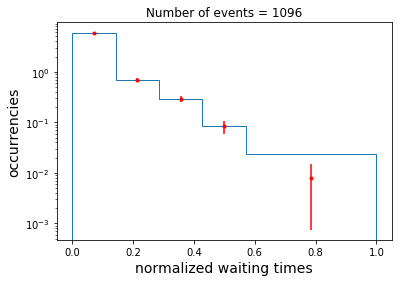

variance of exponent p =  0.1618357686696805

R_max = 1.0 * max_distance
(1100, 7)
(301, 7)
For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1096 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


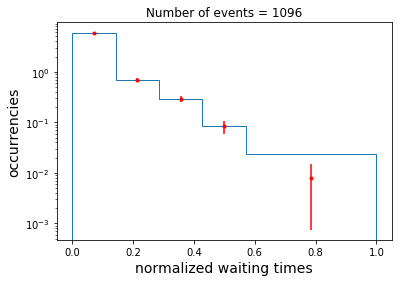

variance of exponent p =  0.1618357686696805

 Number of prime events for this m:  (91, 7)
R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 


R_max = 0.1 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 73 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 73 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 73 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 73 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the fi

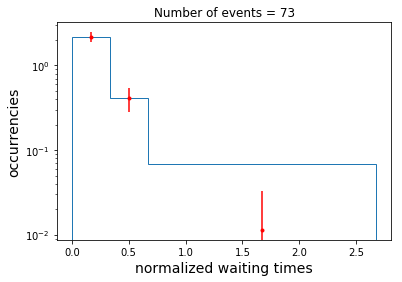

variance of exponent p =  0.17625616817930986

R_max = 0.12405595450583427 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 110 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 110 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 110 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 110 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 110 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


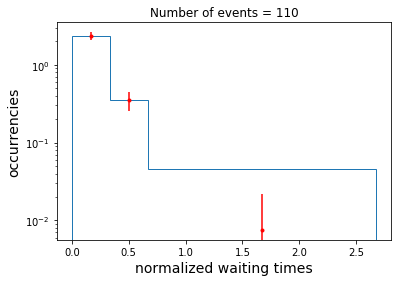

variance of exponent p =  0.17761279004062341

R_max = 0.15070218307242375 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 119 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 119 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 119 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 119 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 119 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


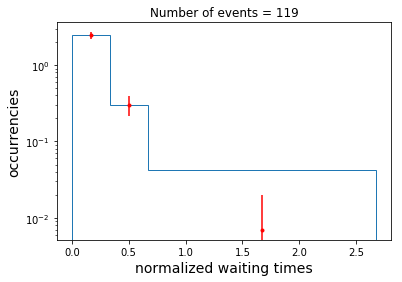

variance of exponent p =  0.12448182506991527

R_max = 0.17993868569976854 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 146 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 146 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 146 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 146 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 146 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


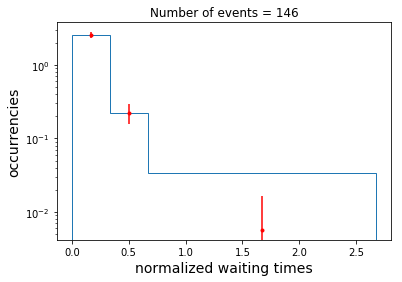

variance of exponent p =  0.05893440765978237

R_max = 0.21176546238786859 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 169 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 169 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 169 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 169 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


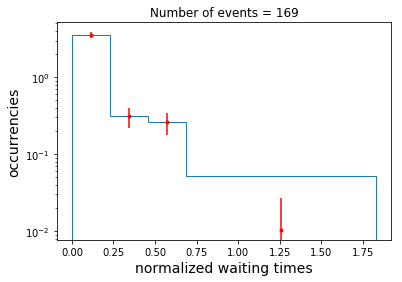

variance of exponent p =  0.1822849479472967

R_max = 0.24618251313672385 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 197 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 197 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 197 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 197 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


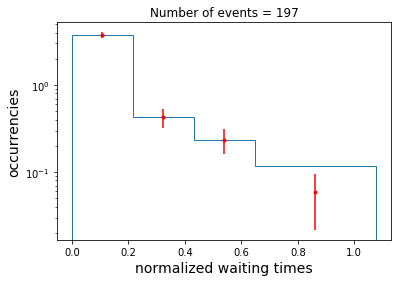

variance of exponent p =  0.02781532616589809

R_max = 0.28318983794633446 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 223 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 223 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 223 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 223 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


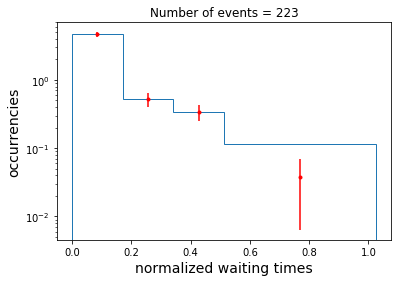

variance of exponent p =  0.09936557059459815

R_max = 0.32278743681670025 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 269 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 269 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 269 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 269 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 269 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


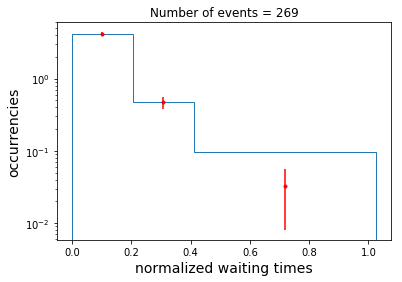

variance of exponent p =  0.11358047888346443

R_max = 0.3649753097478212 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 283 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 283 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 283 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 283 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 283 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


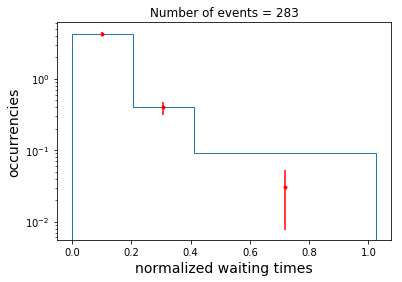

variance of exponent p =  0.06057041030758285

R_max = 0.4097534567396975 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 305 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


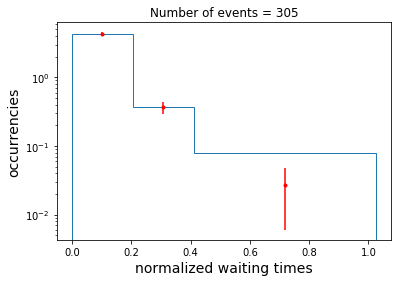

variance of exponent p =  0.05976373780915554

R_max = 0.45712187779232905 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 335 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 335 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 335 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


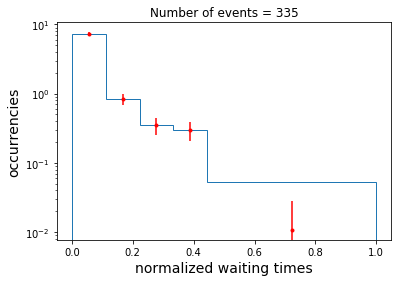

variance of exponent p =  0.17910871398162131

R_max = 0.507080572905716 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 340 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 340 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 340 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 340 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


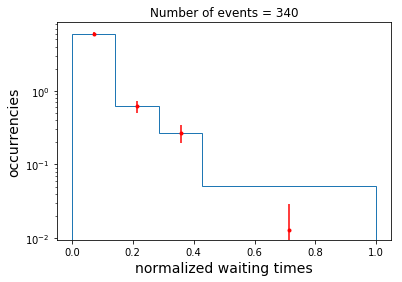

variance of exponent p =  0.17033695348162786

R_max = 0.5596295420798582 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 344 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 344 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 344 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 344 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


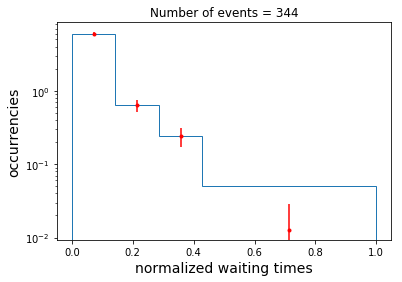

variance of exponent p =  0.15303373768650913

R_max = 0.6147687853147554 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


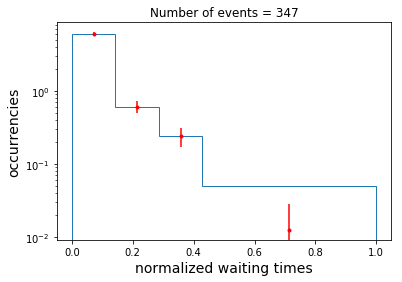

variance of exponent p =  0.14867752254141517

R_max = 0.672498302610408 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


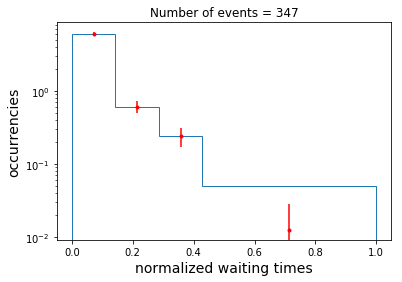

variance of exponent p =  0.14867752254141517

R_max = 0.7328180939668159 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


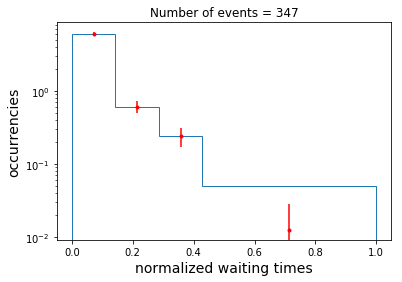

variance of exponent p =  0.14867752254141517

R_max = 0.7957281593839789 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


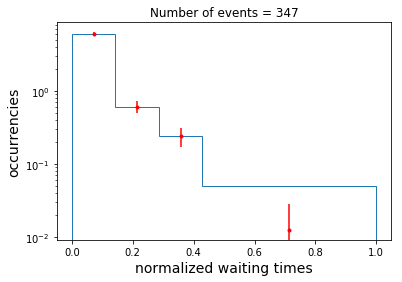

variance of exponent p =  0.14867752254141517

R_max = 0.8612284988618972 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


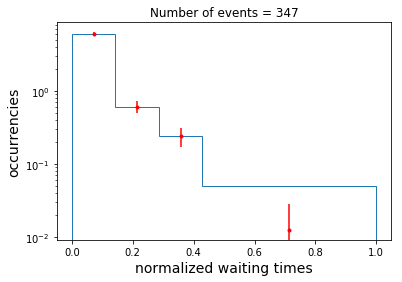

variance of exponent p =  0.14867752254141517

R_max = 0.9293191124005712 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


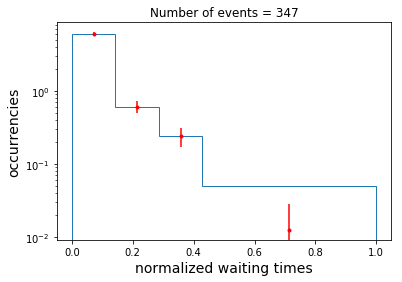

variance of exponent p =  0.14867752254141517

R_max = 1.0 * max_distance
(351, 7)
(91, 7)
For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 347 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


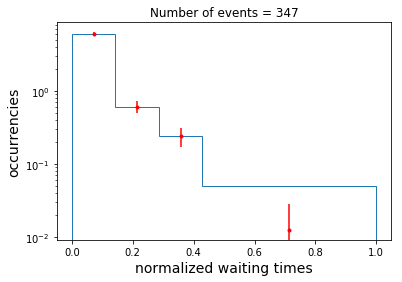

variance of exponent p =  0.14867752254141517


In [136]:
ms = ms = np.linspace(2,4.5,6)
R_fractions = 20
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))
R_max = np.zeros(len(ms))

for i in range(len(ms)):
    Ps[i], Qs[i], P_errors[i], R_max[i] = Pm_t_Rcondition_fixed(ms[i],R_fractions,df)
    

4.9060148800161905


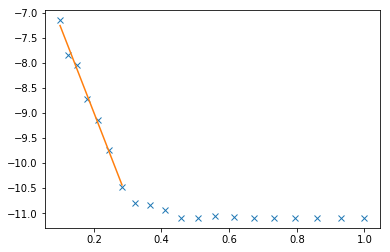

4.942923525600868


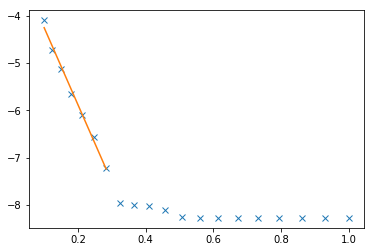

4.749718054615327


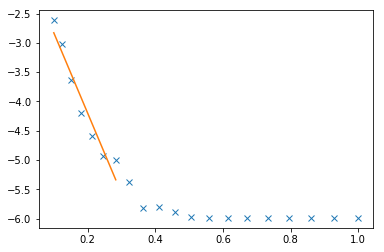

4.482046679594351


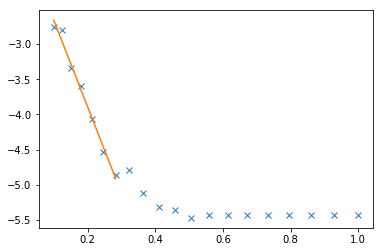

3.022795312408819


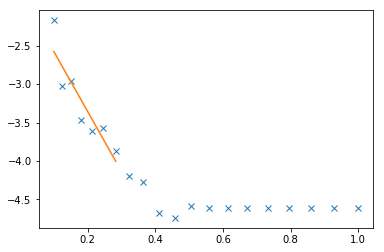

0.13453517862466746


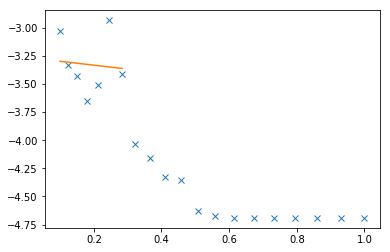

In [147]:
# Find exponent of R using Q

Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2) 

for i in range(len(ms)):
    plt.plot(Rs,Qs[i], 'x')
    param , cov = optimize.curve_fit(linear, Rs[:7],Qs[i,:7])
    x_axis = np.linspace(0.1,Rs[6],100)
    plt.plot(x_axis, linear(x_axis, *param))
    #plt.xscale('log')
    print(param[0]/Ps[i,-1])
    plt.show()


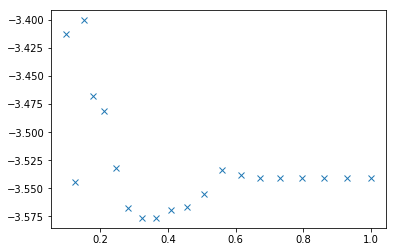

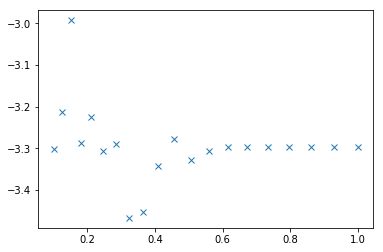

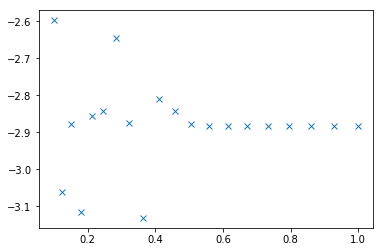

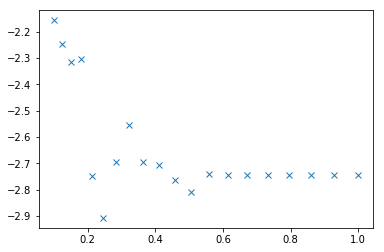

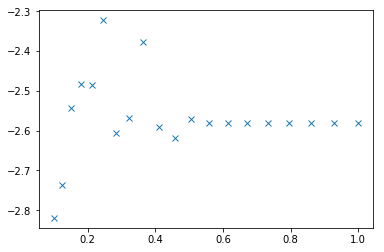

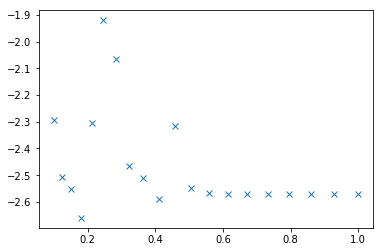

In [148]:
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2) 

for i in range(len(ms)):
    plt.plot(Rs,Ps[i], 'x')
    plt.show()

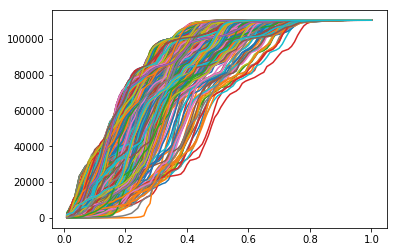

In [118]:
#NUMBER OF EVENTS IN THE SPHERE IN FUNCTION TO THE RADIUS (CENTER IS (0,0,0))

R_res = 100
#Rs = np.power(np.linspace(np.sqrt(0.1),1,R_res) ,2)
Rs = np.linspace(0.01,1,R_res)
X = np.array(df[['x','y','z']])
X = (X - np.mean(X,axis=0))
r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
ev_in_mean_R = np.zeros(R_res)
ev_in_first_R = np.zeros(R_res)

for j in range(1000):
    
    for i in range(len(Rs)):
        #mean_R_mask = ( np.linalg.norm(X, axis=1) <= Rs[i]*r.max() )
        first_R_mask = ( np.linalg.norm(X-X[j], axis=1) <= Rs[i]*r.max() )
        #ev_in_mean_R[i] = df[mean_R_mask].shape[0]
        ev_in_first_R[i] = df[first_R_mask].shape[0]

    #plt.plot(Rs, ev_in_mean_R)
    plt.plot(Rs, ev_in_first_R)
    

plt.show()



# 5 - Scaling properties
Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

## 5.1 - Time scaling with magnitude
First of all we have seen that the exponent $p$ of $P_m(t)$ is linear in m: $p(m) = \alpha + m\beta$

This mean that we can write:  

$P_m(t) = At^{p(m)} = At^{\alpha + m\beta} = P_0(t)t^{m\beta}$

Thus, through the scaling $t_w \rightarrow t_w^{-m\beta}t_w$ we should get the same distribution for the waiting time of events of magnitude > m.

In [40]:
# COPIATO DAL PUNTO 2 DI NICO, SERVE PER TROVARE I p E q PER I VARI m 

def plot_Pm_t2(m, df):
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    prova = time_d[time_d != time_d.max()]
    maximum = prova.max()
    if time_d.max()*3/4 > maximum:
        time_d = prova
    
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
    bin_number = len(bins) - 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    
    #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')
    
    # linear fit over the log of the entries
    params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
    [p,q] = params1
    var_p = np.diag(cov1)[0]

    y_errors = 1./np.sqrt(n)
    ax2.errorbar(np.log(bin_centers), np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
             #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))

    plt.show()
    plt.close()
    
    return p, q, np.sqrt(var_p)


Time distribution for m =  2.0 

For m = 2.0 and N = 106196 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9
Number of bins merged into the tail: 5 



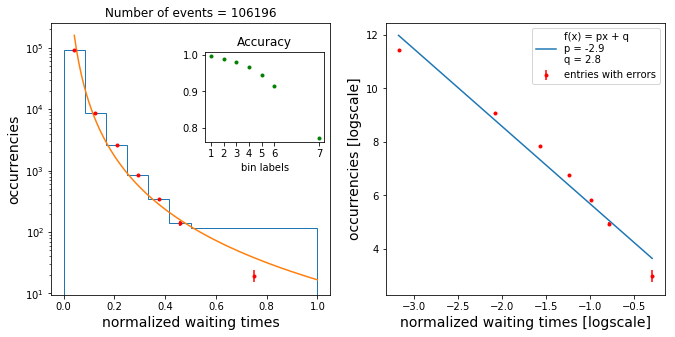


Time distribution for m =  2.5 

For m = 2.5 and N = 37620 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87
Number of bins merged into the tail: 7 



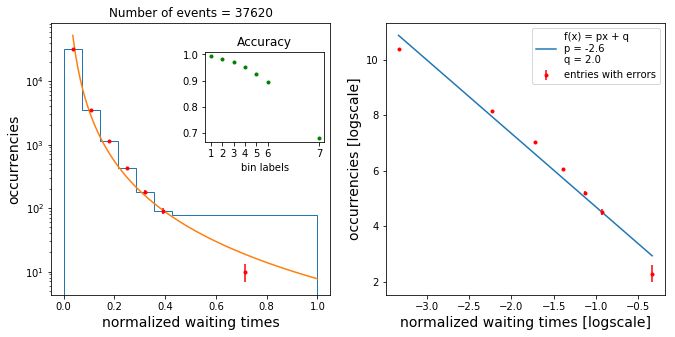


Time distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



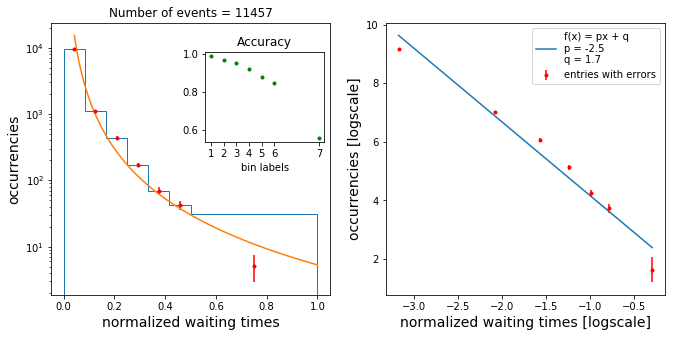


Time distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
Number of bins merged into the tail: 4 



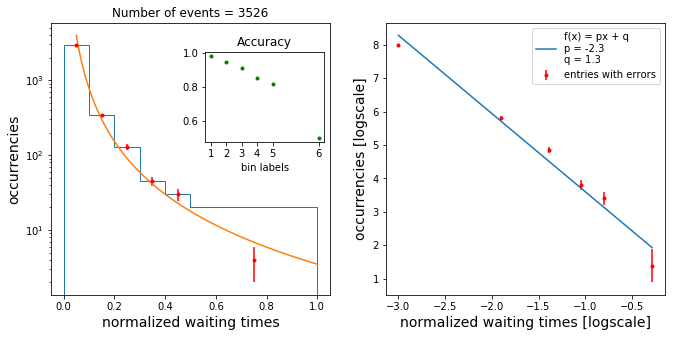


Time distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 



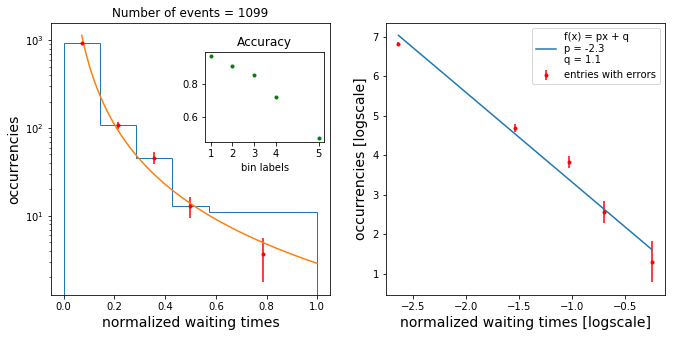


Time distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 



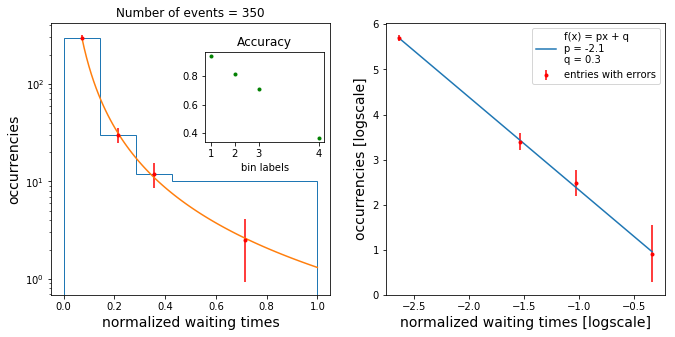

In [41]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.

ms = np.linspace(2,4.5,6)
ps1 = np.zeros(len(ms))
qs1 = np.zeros(len(ms))
p_errors = np.zeros(len(ms))
# we could also use the covariance of the parameters from curve_fit in order to have an error on p !

for i in range(len(ms)):
    m = ms[i]
    ps1[i], qs1[i], p_errors[i] = plot_Pm_t2(m, df)

In [42]:
# Retrieve from point -2.1- the parameters of 𝑝(𝑚)=𝛼+𝑚𝛽

slope, intercept, r_value, p_value, std_err = stats.linregress(ms, ps1)
plt.errorbar(ms, ps1, yerr = p_errors, fmt = '.r', label = 'estimated exponents \nwith errors' )
plt.plot(ms, intercept+slope*ms, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
#plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('exponent p', fontsize = 14)
plt.xlabel('magnitude m', fontsize = 14)
plt.legend()
plt.show()

NameError: name 'stats' is not defined